In [2]:
import networkx as nx
import numpy as np
import random 
import matplotlib.pyplot as plt 
import pandas as pd
import time
import copy

In [10]:
def My_Epi_SI_for_missing_node_method(Graph,initial_nodes, initial_infecteds):
    G=copy.deepcopy(Graph)
    beta=0.001#0.00134228   #0.001121#0.002242           # weight_un=#0.00095969#0.00191938 #0.00136986# previous: 0.0027397
    infected = initial_infecteds.copy()
    N=len(initial_nodes)
    i=4 #number of steps of iteration
    susceptible = list(G.nodes())
    
    for infected_node in infected:
        if infected_node in susceptible: 
            susceptible.remove(infected_node)
    initial_infected_Initial_node_set=[]
    for n in infected:
        if n in initial_nodes:
            initial_infected_Initial_node_set.append(n)
    num_infected_results=[]
    num_infected_results.append(float(len(initial_infected_Initial_node_set)/N))
    num_j=[]
    num_j.append([0,float(len(initial_infected_Initial_node_set)/N)])
    infected_Initial_node_set=[]
    #Inicializar el tiempo
    t = 0
    j=1
    while j<i:
        infected_1 = list()
        #Realizar la infección
        for node in infected: 
            if len(set(G.neighbors(node)))>0:
                '''strategy here is that every time the first chance is get to the highest weight of edges in node neighbors. 
                if rhe neighbor with highest weight does not infect then the second chance is based on random sample choice'''
                edges = list(G.edges(node, data=True))
                if len(edges)==1:
                    neigh=edges[0][1]
                    #neigh=set(G.neighbors(node))
                    if  neigh not in list(infected):
                        if  neigh not in list(infected_1):
                            if random.random()<beta*G[node][neigh]['weight']:
                                infected_1.append(neigh)
                # if len(edges) > 0: #some nodes have zero edges going into it #this one could be useful in directed network
                else:
                    for nbr in set(G.neighbors(node)):
                        if nbr not in list(infected):
                            if  nbr not in list(infected_1):
                                if random.random()<beta*G[node][nbr]['weight']:
                                    infected_1.append(nbr)
        #Remover a los infectados de los susceptibles:
        infected += infected_1
        for infected_node in infected_1:
            if infected_node in susceptible: 
                susceptible.remove(infected_node)
            

        #Registrar el porcentaje de nodos infectados en una lista para luego graficar
        for n in infected:
            if n in initial_nodes:
                if n not in infected_Initial_node_set:
                    infected_Initial_node_set.append(n)
        num_infected_results.append(float(len(infected_Initial_node_set)/N))
        num_j.append([j,float(len(infected)/N)])
        
        #Actualizar el tiempo
        j +=1
                            
    return num_infected_results,num_j

def make_list_node_com(com_dic,key):
    list_n = [nodes for nodes in com_dic.keys()
    if com_dic[nodes] == key]
    return list_n
def get_data_My_SI(Graph, IN_IN):
    I,num_I_j=My_Epi_SI(Graph,IN_IN)
    I1=pd.DataFrame(list(I), columns=['vals'])
    return I1
def multiran_result_SI(Graph,IN_IN):
    dfs_un=pd.DataFrame(list(range(0,100)), columns=['time'])
    for i in range(1,101):
        df_un=get_data_My_SI(Graph,IN_IN)
        dfs_un.insert(i, f"vals_{i}", df_un) 
    df_all_un= dfs_un.set_index('time')
    mean_val_un = df_all_un.iloc[:,0:].mean(axis=1)
    std_val_un= df_all_un.iloc[:,0:].std(axis=1)
    min_val_un = mean_val_un - 2*std_val_un
    max_val_un = mean_val_un + 2*std_val_un
    
    return df_all_un ,  mean_val_un, min_val_un,  max_val_un

def get_data_My_SI_missing_node(Graph,initial_nodes, IN_IN):
    I,num_I_j=My_Epi_SI_for_missing_node_method(Graph,initial_nodes,IN_IN)
    I1=pd.DataFrame(list(I), columns=['vals'])
    return I1
def multiran_result_SI_missing_node(Graph,initial_nodes,IN_IN):
    dfs_un=pd.DataFrame(list(range(0,4)), columns=['time'])
    for i in range(1,51):
        df_un=get_data_My_SI_missing_node(Graph,initial_nodes,IN_IN)
        dfs_un.insert(i, f"vals_{i}", df_un) 
    df_all_un= dfs_un.set_index('time')
    mean_val_un = df_all_un.iloc[:,0:].mean(axis=1)
    std_val_un= df_all_un.iloc[:,0:].std(axis=1)
    min_val_un = mean_val_un - 2*std_val_un
    max_val_un = mean_val_un + 2*std_val_un
    
    return df_all_un ,  mean_val_un, min_val_un,  max_val_un



#add a percent of number of total node to the network

#add missing nodes connected to a random nodes in entire network
def add_uncertainty_node_entire_network_Watt(graph,a,degree): #a=persenctage of number of nodes, degree verfy number of nodes
                                                         # that the added missing nodes will connect to them
    G_original=graph.copy()                                                
    G=copy.deepcopy(graph)
    N_missing_nodes=int((a*0.01)*G.number_of_nodes())

    list_missing_node=[]
    for j in range(N_missing_nodes):
        node_name='Miss'+str(j)
        G.add_node(node_name)
        list_missing_node.append(node_name)
        list_node_connection=list(random.sample(list(G_original.nodes()), degree))
        for item in list_node_connection:
            w_m=np.random.choice(np.arange(1, 11), p=[0.6, 0.08, 0.04, 0.04, 0.04, 0.04,0.04,0.04,0.04,0.04])
            w_a=np.random.choice(np.arange(1, 41))
            w=w_m*w_a
            G.add_edge(node_name,item,weight=w)
          
    return G , list_missing_node            
                
#add missing nodes which are connected to random nodes in a comunity                
def add_uncertainty_node_comunity_Watt(graph,list_n,a,degree): #here we add a percent of the number of nodes in a comunity
    G_original=graph.copy()                                                
    G=copy.deepcopy(graph)
    N_missing_nodes=int((a*0.01)*len(list_n))

    list_missing_node=[]
    for j in range(N_missing_nodes):
        node_name='Miss'+str(j)
        G.add_node(node_name)
        list_missing_node.append(node_name)
        list_node_connection=list(random.sample(list_n, degree))
        for item in list_node_connection:
            w_m=np.random.choice(np.arange(1, 11), p=[0.6, 0.08, 0.04, 0.04, 0.04, 0.04,0.04,0.04,0.04,0.04])
            w_a=np.random.choice(np.arange(1, 41))
            w=w_m*w_a
            G.add_edge(node_name,item,weight=w)
         
    return G , list_missing_node




#******************** NOTE: we should be aware about how we adding missing node to a network. because we should add in a way that the original networl maintain its structure
#for example for barabashi albert I shoud add nodes with the degree that the new network still be a barabashi albert
#add missing nodes connected to a random nodes in entire network
#our original Barabashi etwork is G_Bar=nx.barabasi_albert_graph(n=500, m =5) each new node is connecting to m node
def add_uncertainty_node_entire_network_Bar(graph,a): #a=persenctage of number of nodes, degree verfy number of nodes
                                                         # that the added missing nodes will connect to them
    degree=5
    G_original=graph.copy()                                                
    G=copy.deepcopy(graph)
    N_missing_nodes=int((a*0.01)*G_original.number_of_nodes())
    dic_degree=dict(G_original.degree(weight='weight'))
    sum_degree=sum(dic_degree.values())
    #make a list of probabilit of connecting new noode to original node based on assumption related to barabashi-albert
    #***** this is not fair to start from the highest degree node bacause it has highest probability.
    #I think it is better to shuffle the nodes and start to give a chanse for node in list if they can connect to new node. 
    #when the number of connection is equal to 5 the loop should break
    #           list_probability=[]
    #           for node1 in G_original.nodes():
    #               k=G_original.degree(node1, weight='weight')
    #               list_probability.append((node1,float(k/sum_degree))
    #           list_probability_sort=sorted(list_probability,key=lambda x:x[1],reverse=True) ''' 
    
    list_missing_node=[]
    for j in range(N_missing_nodes):
        m=0 #counter for number of nodes new node in connecting to them. max=5. it should break if m=5
        node_name='Miss'+str(j)
        list_missing_node.append(node_name)
        G.add_node(node_name)
        #random shuffle does not return any list. random shuffle changes the order of nodes in the original list 
        list_original_node=list(G_original.nodes())
        random.shuffle(list_original_node)
        for node1 in list_original_node:
            if m==degree:
                break
            else:
                k=G_original.degree(node1, weight='weight')
                p=float(k/sum_degree)
                if random.random()<p:
                    w=random.randint(1, 50)
                    G.add_edge(node_name,node1,weight=w)
                    m+=1
            
    return G ,list_missing_node           
                
#add missing nodes which are connected to random nodes in a comunity                
def add_uncertainty_node_comunity_Bar(graph,list_n,a): #here we add a percent of the number of nodes in a comunity
    degree=5
    G_original=graph.copy()                                                
    G=copy.deepcopy(graph)
    N_missing_nodes=int((a*0.01)*len(list_n))
    dic_degree=dict(G_original.degree(weight='weight'))
    sum_degree=sum(dic_degree.values())
    
    list_missing_node=[]
    for j in range(N_missing_nodes):
        m=0
        node_name='Miss'+str(j)
        list_missing_node.append(node_name)
        G.add_node(node_name)
         #random shuffle does not return any list. random shuffle changes the order of nodes in the original list 
        list_node_connection=list_n.copy()
        random.shuffle(list_node_connection)
        for node1 in list_node_connection:
            if m==degree:
                break
            else:
                k=G_original.degree(node1, weight='weight')
                p=float(k/sum_degree)
                if random.random()<p:
                    w=random.randint(1, 50)
                    G.add_edge(node_name,node1,weight=w)
                    m+=1
    return G , list_missing_node

#******************** NOTE: we should be aware about how we adding missing node to a network. because we should add in a way that the original networl maintain its structure
#for example for Erdos Reny I should add nodes with the degree that the new network still be a Erdos Reny
#add missing nodes connected to a random nodes in entire network
#our original Barabashi etwork is G_Bar=nx.Erdos_Reny_graph(n=500,p=0.5) each edge is existed in the network by probability p independent of other edges
def add_uncertainty_node_entire_network_Reny(graph,a): #a=persenctage of number of nodes, degree verfy number of nodes
    p=0.5                                                     # that the added missing nodes will connect to them
    G_original=graph.copy()                                                
    G=copy.deepcopy(graph)
    N_missing_nodes=int((a*0.01)*G_original.number_of_nodes())
    list_original_node=list(G_original.nodes())

    
    list_missing_node=[]
    for j in range(N_missing_nodes):
        node_name='Miss'+str(j)
        list_missing_node.append(node_name)
        G.add_node(node_name)
        
        for node1 in list_original_node:
            if random.random()<p:
                    #assumption on weights I assumed for constructing the original erdos reny network
                w_m=np.random.choice(np.arange(1, 11), p=[0.8, 0.04, 0.02, 0.02, 0.02, 0.02,0.02,0.02,0.02,0.02]) #int(1.64 * np.random.randn() + 1.53) # this distribution can give 0 or negative value which is not suitable for my code
                w_a=random.randint(1, 50)                            
                w=w_m*w_a
                G.add_edge(node_name,node1,weight=w)
                    
            
    return G ,list_missing_node           
                
#add missing nodes which are connected to random nodes in a comunity                
def add_uncertainty_node_comunity_Reny(graph,list_n,a): #here we add a percent of the number of nodes in a comunity
    p=0.5                                                     # that the added missing nodes will connect to them
    G_original=graph.copy()                                                
    G=copy.deepcopy(graph)
    N_missing_nodes=int((a*0.01)*len(list_n))
    list_original_node=list(G_original.nodes())
    list_node_connection=list_n.copy()

    
    list_missing_node=[]
    for j in range(N_missing_nodes):
        node_name='Miss'+str(j)
        list_missing_node.append(node_name)
        G.add_node(node_name)
        
        for node1 in list_node_connection:
            if random.random()<p:
                    #assumption on weights I assumed for constructing the original erdos reny network
                w_m=np.random.choice(np.arange(1, 11), p=[0.8, 0.04, 0.02, 0.02, 0.02, 0.02,0.02,0.02,0.02,0.02]) #int(1.64 * np.random.randn() + 1.53) # this distribution can give 0 or negative value which is not suitable for my code
                w_a=random.randint(1, 50)                            
                w=w_m*w_a
                G.add_edge(node_name,node1,weight=w)
                    
            
    return G ,list_missing_node           
    



###### read G_Bar and G_Watt network from files

In [27]:
G_Bar=nx.read_weighted_edgelist('G_Bar.weighted.edgelist')
IN_IN_Bar_com1=['426', '59', '380', '161', '66']


In [189]:
Com_G_Bar={0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 1,
 6: 5,
 7: 4,
 8: 6,
 9: 5,
 10: 2,
 11: 1,
 12: 7,
 13: 4,
 14: 5,
 15: 7,
 16: 8,
 17: 4,
 18: 0,
 19: 4,
 20: 1,
 21: 6,
 22: 7,
 23: 4,
 24: 8,
 25: 9,
 26: 6,
 27: 7,
 28: 10,
 29: 2,
 30: 11,
 31: 12,
 32: 12,
 33: 8,
 34: 11,
 35: 7,
 36: 2,
 37: 13,
 38: 11,
 39: 3,
 40: 5,
 41: 7,
 42: 2,
 43: 4,
 44: 4,
 45: 7,
 46: 12,
 47: 8,
 48: 10,
 49: 14,
 50: 10,
 51: 7,
 52: 13,
 53: 2,
 54: 5,
 55: 9,
 56: 7,
 57: 4,
 58: 2,
 59: 4,
 60: 12,
 61: 14,
 62: 2,
 63: 7,
 64: 1,
 65: 10,
 66: 4,
 67: 14,
 68: 2,
 69: 10,
 70: 15,
 71: 12,
 72: 10,
 73: 15,
 74: 0,
 75: 4,
 76: 3,
 77: 14,
 78: 8,
 79: 8,
 80: 15,
 81: 8,
 82: 9,
 83: 15,
 84: 10,
 85: 14,
 86: 13,
 87: 2,
 88: 4,
 89: 7,
 90: 4,
 91: 13,
 92: 4,
 93: 4,
 94: 5,
 95: 10,
 96: 0,
 97: 8,
 98: 4,
 99: 11,
 100: 10,
 101: 0,
 102: 8,
 103: 1,
 104: 2,
 105: 7,
 106: 1,
 107: 4,
 108: 6,
 109: 14,
 110: 15,
 111: 2,
 112: 15,
 113: 6,
 114: 4,
 115: 8,
 116: 15,
 117: 6,
 118: 2,
 119: 7,
 120: 4,
 121: 12,
 122: 6,
 123: 14,
 124: 10,
 125: 15,
 126: 5,
 127: 15,
 128: 7,
 129: 6,
 130: 8,
 131: 2,
 132: 7,
 133: 8,
 134: 0,
 135: 11,
 136: 3,
 137: 15,
 138: 9,
 139: 2,
 140: 1,
 141: 3,
 142: 2,
 143: 13,
 144: 4,
 145: 1,
 146: 13,
 147: 14,
 148: 1,
 149: 7,
 150: 4,
 151: 11,
 152: 11,
 153: 4,
 154: 13,
 155: 13,
 156: 8,
 157: 2,
 158: 11,
 159: 10,
 160: 6,
 161: 4,
 162: 15,
 163: 15,
 164: 14,
 165: 7,
 166: 14,
 167: 3,
 168: 11,
 169: 7,
 170: 10,
 171: 0,
 172: 2,
 173: 1,
 174: 10,
 175: 11,
 176: 14,
 177: 10,
 178: 12,
 179: 5,
 180: 12,
 181: 4,
 182: 8,
 183: 11,
 184: 8,
 185: 14,
 186: 4,
 187: 0,
 188: 1,
 189: 0,
 190: 11,
 191: 15,
 192: 4,
 193: 4,
 194: 11,
 195: 1,
 196: 7,
 197: 9,
 198: 4,
 199: 2,
 200: 13,
 201: 4,
 202: 9,
 203: 5,
 204: 14,
 205: 15,
 206: 4,
 207: 1,
 208: 13,
 209: 2,
 210: 4,
 211: 2,
 212: 10,
 213: 7,
 214: 4,
 215: 6,
 216: 2,
 217: 8,
 218: 14,
 219: 8,
 220: 7,
 221: 14,
 222: 5,
 223: 11,
 224: 6,
 225: 6,
 226: 4,
 227: 5,
 228: 3,
 229: 10,
 230: 4,
 231: 8,
 232: 13,
 233: 14,
 234: 2,
 235: 8,
 236: 6,
 237: 14,
 238: 11,
 239: 10,
 240: 8,
 241: 5,
 242: 11,
 243: 0,
 244: 10,
 245: 6,
 246: 8,
 247: 8,
 248: 14,
 249: 6,
 250: 4,
 251: 14,
 252: 6,
 253: 14,
 254: 2,
 255: 8,
 256: 13,
 257: 15,
 258: 1,
 259: 1,
 260: 5,
 261: 14,
 262: 12,
 263: 4,
 264: 11,
 265: 8,
 266: 5,
 267: 15,
 268: 0,
 269: 11,
 270: 15,
 271: 13,
 272: 14,
 273: 12,
 274: 3,
 275: 5,
 276: 9,
 277: 14,
 278: 14,
 279: 7,
 280: 2,
 281: 14,
 282: 15,
 283: 13,
 284: 13,
 285: 5,
 286: 4,
 287: 10,
 288: 11,
 289: 1,
 290: 7,
 291: 4,
 292: 3,
 293: 4,
 294: 1,
 295: 3,
 296: 4,
 297: 0,
 298: 12,
 299: 5,
 300: 9,
 301: 6,
 302: 2,
 303: 10,
 304: 4,
 305: 10,
 306: 4,
 307: 0,
 308: 6,
 309: 7,
 310: 9,
 311: 5,
 312: 9,
 313: 12,
 314: 9,
 315: 2,
 316: 2,
 317: 13,
 318: 9,
 319: 8,
 320: 13,
 321: 11,
 322: 14,
 323: 13,
 324: 1,
 325: 1,
 326: 11,
 327: 2,
 328: 4,
 329: 4,
 330: 4,
 331: 11,
 332: 1,
 333: 8,
 334: 0,
 335: 4,
 336: 1,
 337: 6,
 338: 11,
 339: 3,
 340: 6,
 341: 0,
 342: 13,
 343: 11,
 344: 9,
 345: 7,
 346: 5,
 347: 11,
 348: 1,
 349: 3,
 350: 1,
 351: 5,
 352: 6,
 353: 3,
 354: 8,
 355: 14,
 356: 15,
 357: 0,
 358: 14,
 359: 8,
 360: 7,
 361: 2,
 362: 8,
 363: 1,
 364: 1,
 365: 11,
 366: 3,
 367: 8,
 368: 7,
 369: 6,
 370: 4,
 371: 3,
 372: 6,
 373: 4,
 374: 15,
 375: 2,
 376: 6,
 377: 7,
 378: 4,
 379: 6,
 380: 4,
 381: 0,
 382: 4,
 383: 4,
 384: 12,
 385: 2,
 386: 14,
 387: 2,
 388: 3,
 389: 2,
 390: 4,
 391: 3,
 392: 1,
 393: 12,
 394: 8,
 395: 10,
 396: 13,
 397: 8,
 398: 1,
 399: 14,
 400: 9,
 401: 9,
 402: 3,
 403: 4,
 404: 15,
 405: 7,
 406: 4,
 407: 10,
 408: 0,
 409: 8,
 410: 9,
 411: 13,
 412: 11,
 413: 11,
 414: 11,
 415: 11,
 416: 8,
 417: 14,
 418: 10,
 419: 2,
 420: 9,
 421: 11,
 422: 1,
 423: 14,
 424: 3,
 425: 2,
 426: 4,
 427: 13,
 428: 7,
 429: 1,
 430: 14,
 431: 4,
 432: 2,
 433: 14,
 434: 1,
 435: 4,
 436: 10,
 437: 12,
 438: 9,
 439: 15,
 440: 13,
 441: 8,
 442: 14,
 443: 5,
 444: 13,
 445: 1,
 446: 15,
 447: 11,
 448: 10,
 449: 3,
 450: 4,
 451: 14,
 452: 14,
 453: 13,
 454: 15,
 455: 10,
 456: 7,
 457: 5,
 458: 2,
 459: 0,
 460: 1,
 461: 13,
 462: 8,
 463: 1,
 464: 1,
 465: 7,
 466: 5,
 467: 10,
 468: 11,
 469: 4,
 470: 11,
 471: 5,
 472: 1,
 473: 8,
 474: 0,
 475: 7,
 476: 7,
 477: 5,
 478: 4,
 479: 5,
 480: 7,
 481: 8,
 482: 10,
 483: 4,
 484: 13,
 485: 1,
 486: 8,
 487: 14,
 488: 15,
 489: 10,
 490: 0,
 491: 2,
 492: 0,
 493: 4,
 494: 8,
 495: 5,
 496: 6,
 497: 13,
 498: 13,
 499: 13}
Bar_com_dam_error=make_list_node_com(Com_G_Bar,4)
Bar_com_1=[]
for item in Bar_com_dam_error:
    Bar_com_1.append(str(item))

In [215]:
#make missing node networks
initial_nodes_Bar=list(G_Bar.nodes())

# make just one network with a certain number of new missing nodes
#then we want to analyse how much of this missing node should be initial infected until the epidemic behaviour of original network change
#so we need one add miss node to entire and one to comunity but we need different set of initial infected nodes
#we assess just the infected cases of the initial nodes
 #for entire network 20%/50% number of totall nodes
MN_Bar_20, list_MN_entire_20=add_uncertainty_node_entire_network_Bar(G_Bar,20)
MN_Bar_com_20, list_MN_com_20=add_uncertainty_node_comunity_Bar(G_Bar,Bar_com_1,20)
MN_Bar_50, list_MN_entire_50=add_uncertainty_node_entire_network_Bar(G_Bar,50)
MN_Bar_com_50, list_MN_com_50=add_uncertainty_node_comunity_Bar(G_Bar,Bar_com_1,50)

In [217]:
#make initial infected nodes from the node set that was added to the network as missing node
#5 different initial infected nodes. we increase the number of missing nodes in initial infected set
#Initial infected set for original network
IN_IN_Bar1=IN_IN_Bar_com1
#Initial infected set for network with 20 % extra missing nodes added to entire network (20% number of node in entire network)
IN_IN_Bar_20_c1=IN_IN_Bar_com1+list(random.sample(list_MN_com_20, int(0.05*len(list_MN_com_20))))
IN_IN_Bar_20_c2=IN_IN_Bar_com1+list(random.sample(list_MN_com_20, int(0.1*len(list_MN_com_20))))
IN_IN_Bar_20_c3=IN_IN_Bar_com1+list(random.sample(list_MN_com_20, int(0.5*len(list_MN_com_20))))
IN_IN_Bar_20_c4=IN_IN_Bar_com1+list_MN_com_20
#Initial infected set for network with 20 % extra missing nodes added to comunity (20% number of node in entire network)
IN_IN_Bar2_20=IN_IN_Bar_com1+list(random.sample(list_MN_entire_20, int(0.05*len(list_MN_entire_20))))
IN_IN_Bar3_20=IN_IN_Bar_com1+list(random.sample(list_MN_entire_20, int(0.1*len(list_MN_entire_20))))
IN_IN_Bar4_20=IN_IN_Bar_com1+list(random.sample(list_MN_entire_20, int(0.5*len(list_MN_entire_20))))
IN_IN_Bar5_20=IN_IN_Bar_com1+list_MN_entire_20


#Initial infected set for network with 50 % extra missing nodes added to entire network (20% number of node in entire network)
IN_IN_Bar_50_c1=IN_IN_Bar_com1+list(random.sample(list_MN_com_50, int(0.05*len(list_MN_com_50))))
IN_IN_Bar_50_c2=IN_IN_Bar_com1+list(random.sample(list_MN_com_50, int(0.1*len(list_MN_com_50))))
IN_IN_Bar_50_c3=IN_IN_Bar_com1+list(random.sample(list_MN_com_50, int(0.5*len(list_MN_com_50))))
IN_IN_Bar_50_c4=IN_IN_Bar_com1+list_MN_com_50
#Initial infected set for network with 50 % extra missing nodes added to comunity (20% number of node in entire network)
IN_IN_Bar2_50=IN_IN_Bar_com1+list(random.sample(list_MN_entire_50, int(0.05*len(list_MN_entire_50))))
IN_IN_Bar3_50=IN_IN_Bar_com1+list(random.sample(list_MN_entire_50, int(0.1*len(list_MN_entire_50))))
IN_IN_Bar4_50=IN_IN_Bar_com1+list(random.sample(list_MN_entire_50, int(0.5*len(list_MN_entire_50))))
IN_IN_Bar5_50=IN_IN_Bar_com1+list_MN_entire_50

In [267]:
#new assumtion
#original network
dfe, dfe_mean, dfe_min, dfe_max=multiran_result_SI_missing_node(G_Bar,initial_nodes_Bar,IN_IN_Bar1)

#increasing number of initial infected nodes which are in missing node set. number of missing nodes is 20% of total number of nodes in entire network 
df_e1_20, df_e1_20_mean, df_e1_20_min,df_e1_20_max=multiran_result_SI_missing_node(MN_Bar_20,initial_nodes_Bar,IN_IN_Bar2_20)
df_e2_20, df_e2_20_mean, df_e2_20_min,df_e2_20_max=multiran_result_SI_missing_node(MN_Bar_20,initial_nodes_Bar,IN_IN_Bar3_20)
df_e3_20, df_e3_20_mean, df_e3_20_min,df_e3_20_max=multiran_result_SI_missing_node(MN_Bar_20,initial_nodes_Bar,IN_IN_Bar4_20)
df_e4_20, df_e4_20_mean, df_e4_20_min,df_e4_20_max=multiran_result_SI_missing_node(MN_Bar_20,initial_nodes_Bar,IN_IN_Bar5_20)

#increasing number of initial infected nodes which are in missing node set. number of missing nodes is 0% of total number of nodes in comunity 
#dfc, dfc_mean, dfc_min, dfc_max=multiran_result_SI_missing_node(G_Bar,initial_nodes_Bar,IN_IN_Bar1)
df_c1_20, df_c1_20_mean, df_c1_20_min,df_c1_20_max=multiran_result_SI_missing_node(MN_Bar_com_20,initial_nodes_Bar,IN_IN_Bar_20_c1)
df_c2_20, df_c2_20_mean, df_c2_20_min,df_c2_20_max=multiran_result_SI_missing_node(MN_Bar_com_20,initial_nodes_Bar,IN_IN_Bar_20_c2)
df_c3_20, df_c3_20_mean, df_c3_20_min,df_c3_20_max=multiran_result_SI_missing_node(MN_Bar_com_20,initial_nodes_Bar,IN_IN_Bar_20_c3)
df_c4_20, df_c4_20_mean, df_c4_20_min,df_c4_20_max=multiran_result_SI_missing_node(MN_Bar_com_20,initial_nodes_Bar,IN_IN_Bar_20_c4)


#increasing number of initial infected nodes which are in missing node set. number of missing nodes is 50% of total number of nodes in entire network 
df_e1_50, df_e1_50_mean, df_e1_50_min,df_e1_50_max=multiran_result_SI_missing_node(MN_Bar_50,initial_nodes_Bar,IN_IN_Bar2_50)
df_e2_50, df_e2_50_mean, df_e2_50_min,df_e2_50_max=multiran_result_SI_missing_node(MN_Bar_50,initial_nodes_Bar,IN_IN_Bar3_50)
df_e3_50, df_e3_50_mean, df_e3_50_min,df_e3_50_max=multiran_result_SI_missing_node(MN_Bar_50,initial_nodes_Bar,IN_IN_Bar4_50)
df_e4_50, df_e4_50_mean, df_e4_50_min,df_e4_50_max=multiran_result_SI_missing_node(MN_Bar_50,initial_nodes_Bar,IN_IN_Bar5_50)

#increasing number of initial infected nodes which are in missing node set. number of missing nodes is 50% of total number of nodes in comunity 
df_c1_50, df_c1_50_mean, df_c1_50_min,df_c1_50_max=multiran_result_SI_missing_node(MN_Bar_com_50,initial_nodes_Bar,IN_IN_Bar_50_c1)
df_c2_50, df_c2_50_mean, df_c2_50_min,df_c2_50_max=multiran_result_SI_missing_node(MN_Bar_com_50,initial_nodes_Bar,IN_IN_Bar_50_c2)
df_c3_50, df_c3_50_mean, df_c3_50_min,df_c3_50_max=multiran_result_SI_missing_node(MN_Bar_com_50,initial_nodes_Bar,IN_IN_Bar_50_c3)
df_c4_50, df_c4_50_mean, df_c4_50_min,df_c4_50_max=multiran_result_SI_missing_node(MN_Bar_com_50,initial_nodes_Bar,IN_IN_Bar_50_c4)

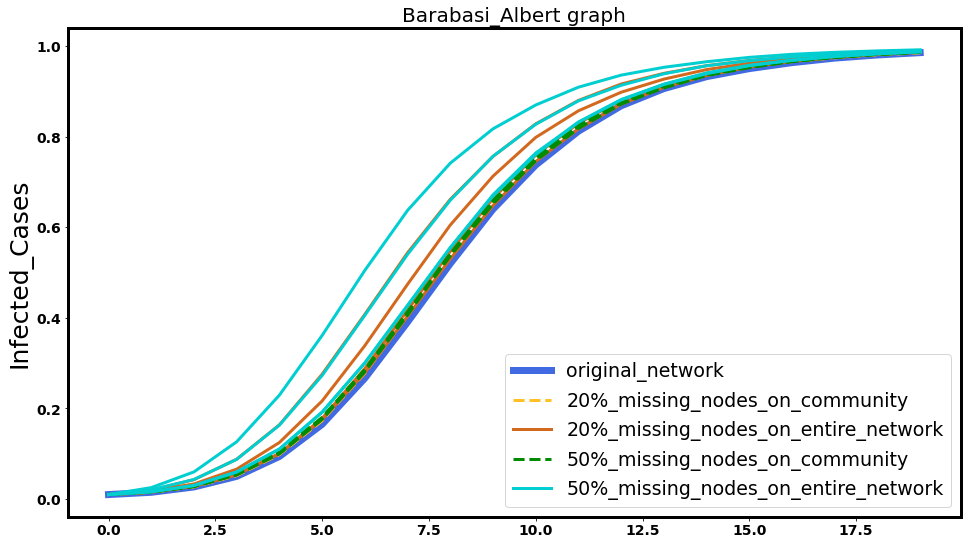

In [269]:
fig, ax = plt.subplots(1,1,figsize=(16,9))



plt.plot(dfe.index, dfe_mean,c='royalblue',label='original_network',linewidth=7.0)
#plt.fill_between(df.index, df_min, df_max, color='blue', alpha=.2)

plt.plot(df_c1_20.index, df_c1_20_mean,c='#FFC125',linestyle='--',label='20%_missing_nodes_on_community',linewidth=3.0)
#plt.fill_between(df_un10_com1.index, df_un10_com1_min, df_un10_com1_max, color='goldenrod', alpha=.2)
plt.plot(df_c2_20.index, df_c2_20_mean,c='#FFC125',linestyle='--',linewidth=3.0)
#plt.fill_between(df_un10_entire.index, df_un10_entire_min, df_un10_entire_max, color='chocolate', alpha=.2)
plt.plot(df_c3_20.index, df_c3_20_mean,c='#FFC125',linestyle='--',linewidth=3.0)
#plt.fill_between(df_un50_com1.index, df_un50_com1_min, df_un50_com1_max, color='lightskyblue', alpha=.2)
plt.plot(df_c4_20.index, df_c4_20_mean,c='#FFC125',linestyle='--',linewidth=3.0)
#plt.fill_between(df_un50_entire.index, df_un50_entire_min, df_un50_entire_max, color='mediumseagreen', alpha=.2)

plt.plot(df_e1_20.index, df_e1_20_mean,c='chocolate',label='20%_missing_nodes_on_entire_network',linewidth=3.0)
#plt.fill_between(df_un10_com1.index, df_un10_com1_min, df_un10_com1_max, color='goldenrod', alpha=.2)
plt.plot(df_e2_20.index, df_e2_20_mean,c='chocolate',linewidth=3.0)
#plt.fill_between(df_un10_entire.index, df_un10_entire_min, df_un10_entire_max, color='chocolate', alpha=.2)
plt.plot(df_e3_20.index, df_e3_20_mean,c='chocolate',linewidth=3.0)
#plt.fill_between(df_un50_com1.index, df_un50_com1_min, df_un50_com1_max, color='lightskyblue', alpha=.2)
plt.plot(df_e4_20.index, df_e4_20_mean,c='chocolate',linewidth=3.0)
#plt.fill_between(df_un50_entire.index, df_un50_entire_min, df_un50_entire_max, color='mediumseagreen', alpha=.2)


plt.plot(df_c1_50.index, df_c1_50_mean,c='#008B00',linestyle='--',label='50%_missing_nodes_on_community',linewidth=3.0)
#plt.fill_between(df_un10_com1.index, df_un10_com1_min, df_un10_com1_max, color='goldenrod', alpha=.2)
plt.plot(df_c2_50.index, df_c2_50_mean,c='#008B00',linestyle='--',linewidth=3.0)
#plt.fill_between(df_un10_entire.index, df_un10_entire_min, df_un10_entire_max, color='chocolate', alpha=.2)
plt.plot(df_c3_50.index, df_c3_50_mean,c='#008B00',linestyle='--',linewidth=3.0)
#plt.fill_between(df_un50_com1.index, df_un50_com1_min, df_un50_com1_max, color='lightskyblue', alpha=.2)
plt.plot(df_c4_50.index, df_c4_50_mean,c='#008B00',linestyle='--',linewidth=3.0)
#plt.fill_between(df_un50_entire.index, df_un50_entire_min, df_un50_entire_max, color='mediumseagreen', alpha=.2)

plt.plot(df_e1_50.index, df_e1_50_mean,c='darkturquoise',label='50%_missing_nodes_on_entire_network',linewidth=3.0)
#plt.fill_between(df_un10_com1.index, df_un10_com1_min, df_un10_com1_max, color='goldenrod', alpha=.2)
plt.plot(df_e2_50.index, df_e2_50_mean,c='darkturquoise',linewidth=3.0)
#plt.fill_between(df_un10_entire.index, df_un10_entire_min, df_un10_entire_max, color='chocolate', alpha=.2)
plt.plot(df_e3_50.index, df_e3_50_mean,c='darkturquoise',linewidth=3.0)
#plt.fill_between(df_un50_com1.index, df_un50_com1_min, df_un50_com1_max, color='lightskyblue', alpha=.2)
plt.plot(df_e4_50.index, df_e4_50_mean,c='darkturquoise',linewidth=3.0)
#plt.fill_between(df_un50_entire.index, df_un50_entire_min, df_un50_entire_max, color='mediumseagreen', alpha=.2)





fontsize = 14

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.rc('axes', linewidth=3)
#plt.ylim(0,0.35)
plt.xlabel('')
plt.ylabel('Infected_Cases',fontsize=25)
plt.title('Barabasi_Albert graph',fontsize=20)
plt.legend(fontsize=19)
#plt.xlim(0,20)
plt.savefig('MN_Bar_20-50ofcomNodes_to_com_SI0.001_5-10-10-100%number_infected.pdf')


#### Watts Strogats

In [164]:
G_Watt=nx.nx.read_gpickle('G_Watt.gpickle')
IN_IN_Watt_com1=[69, 68, 339, 492, 478]

Com_G_Watt={0: 0,
 1: 1,
 2: 2,
 3: 0,
 4: 3,
 5: 4,
 6: 3,
 7: 5,
 8: 6,
 9: 7,
 10: 8,
 11: 9,
 12: 10,
 13: 10,
 14: 11,
 15: 11,
 16: 12,
 17: 13,
 18: 13,
 19: 13,
 20: 13,
 21: 13,
 22: 13,
 23: 13,
 24: 14,
 25: 13,
 26: 15,
 27: 10,
 28: 14,
 29: 15,
 30: 11,
 31: 0,
 32: 11,
 33: 11,
 34: 0,
 35: 5,
 36: 0,
 37: 16,
 38: 17,
 39: 16,
 40: 17,
 41: 17,
 42: 17,
 43: 17,
 44: 17,
 45: 17,
 46: 17,
 47: 17,
 48: 17,
 49: 17,
 50: 17,
 51: 18,
 52: 19,
 53: 18,
 54: 18,
 55: 18,
 56: 5,
 57: 18,
 58: 18,
 59: 5,
 60: 5,
 61: 16,
 62: 5,
 63: 5,
 64: 10,
 65: 11,
 66: 17,
 67: 6,
 68: 6,
 69: 6,
 70: 12,
 71: 6,
 72: 6,
 73: 6,
 74: 6,
 75: 6,
 76: 6,
 77: 6,
 78: 12,
 79: 15,
 80: 17,
 81: 14,
 82: 17,
 83: 20,
 84: 20,
 85: 19,
 86: 19,
 87: 6,
 88: 6,
 89: 17,
 90: 2,
 91: 2,
 92: 2,
 93: 2,
 94: 2,
 95: 21,
 96: 22,
 97: 22,
 98: 19,
 99: 0,
 100: 5,
 101: 23,
 102: 22,
 103: 5,
 104: 5,
 105: 5,
 106: 5,
 107: 13,
 108: 5,
 109: 5,
 110: 7,
 111: 7,
 112: 11,
 113: 15,
 114: 19,
 115: 9,
 116: 19,
 117: 9,
 118: 9,
 119: 19,
 120: 13,
 121: 9,
 122: 10,
 123: 9,
 124: 17,
 125: 13,
 126: 9,
 127: 13,
 128: 21,
 129: 15,
 130: 14,
 131: 21,
 132: 3,
 133: 12,
 134: 20,
 135: 20,
 136: 17,
 137: 4,
 138: 23,
 139: 16,
 140: 17,
 141: 16,
 142: 21,
 143: 24,
 144: 1,
 145: 10,
 146: 4,
 147: 1,
 148: 10,
 149: 1,
 150: 1,
 151: 10,
 152: 1,
 153: 3,
 154: 6,
 155: 2,
 156: 3,
 157: 18,
 158: 14,
 159: 3,
 160: 3,
 161: 3,
 162: 15,
 163: 15,
 164: 9,
 165: 15,
 166: 9,
 167: 18,
 168: 20,
 169: 14,
 170: 2,
 171: 14,
 172: 20,
 173: 13,
 174: 14,
 175: 20,
 176: 5,
 177: 14,
 178: 14,
 179: 11,
 180: 10,
 181: 16,
 182: 3,
 183: 25,
 184: 25,
 185: 25,
 186: 25,
 187: 25,
 188: 7,
 189: 7,
 190: 7,
 191: 7,
 192: 7,
 193: 7,
 194: 12,
 195: 7,
 196: 7,
 197: 7,
 198: 7,
 199: 20,
 200: 7,
 201: 16,
 202: 4,
 203: 18,
 204: 1,
 205: 8,
 206: 7,
 207: 8,
 208: 18,
 209: 18,
 210: 18,
 211: 4,
 212: 18,
 213: 0,
 214: 4,
 215: 23,
 216: 0,
 217: 25,
 218: 0,
 219: 22,
 220: 22,
 221: 22,
 222: 13,
 223: 22,
 224: 10,
 225: 23,
 226: 23,
 227: 3,
 228: 23,
 229: 13,
 230: 3,
 231: 23,
 232: 25,
 233: 25,
 234: 5,
 235: 13,
 236: 8,
 237: 10,
 238: 14,
 239: 8,
 240: 17,
 241: 14,
 242: 22,
 243: 18,
 244: 14,
 245: 14,
 246: 14,
 247: 14,
 248: 14,
 249: 14,
 250: 11,
 251: 11,
 252: 3,
 253: 4,
 254: 21,
 255: 4,
 256: 21,
 257: 21,
 258: 0,
 259: 21,
 260: 14,
 261: 14,
 262: 1,
 263: 8,
 264: 14,
 265: 20,
 266: 13,
 267: 20,
 268: 21,
 269: 20,
 270: 20,
 271: 15,
 272: 16,
 273: 16,
 274: 25,
 275: 16,
 276: 25,
 277: 25,
 278: 25,
 279: 9,
 280: 9,
 281: 9,
 282: 9,
 283: 9,
 284: 20,
 285: 9,
 286: 9,
 287: 1,
 288: 1,
 289: 22,
 290: 14,
 291: 17,
 292: 5,
 293: 17,
 294: 11,
 295: 0,
 296: 1,
 297: 2,
 298: 10,
 299: 19,
 300: 19,
 301: 10,
 302: 3,
 303: 11,
 304: 19,
 305: 19,
 306: 11,
 307: 11,
 308: 11,
 309: 11,
 310: 11,
 311: 13,
 312: 16,
 313: 19,
 314: 5,
 315: 21,
 316: 24,
 317: 24,
 318: 22,
 319: 19,
 320: 19,
 321: 1,
 322: 15,
 323: 15,
 324: 6,
 325: 15,
 326: 0,
 327: 15,
 328: 15,
 329: 15,
 330: 15,
 331: 17,
 332: 17,
 333: 16,
 334: 15,
 335: 22,
 336: 8,
 337: 9,
 338: 9,
 339: 6,
 340: 9,
 341: 5,
 342: 9,
 343: 21,
 344: 19,
 345: 12,
 346: 21,
 347: 12,
 348: 2,
 349: 12,
 350: 16,
 351: 16,
 352: 16,
 353: 17,
 354: 16,
 355: 16,
 356: 6,
 357: 16,
 358: 21,
 359: 0,
 360: 0,
 361: 0,
 362: 0,
 363: 0,
 364: 0,
 365: 21,
 366: 0,
 367: 0,
 368: 14,
 369: 3,
 370: 13,
 371: 18,
 372: 17,
 373: 15,
 374: 18,
 375: 17,
 376: 18,
 377: 18,
 378: 18,
 379: 18,
 380: 18,
 381: 6,
 382: 6,
 383: 12,
 384: 18,
 385: 12,
 386: 23,
 387: 21,
 388: 4,
 389: 20,
 390: 11,
 391: 11,
 392: 6,
 393: 22,
 394: 11,
 395: 18,
 396: 11,
 397: 17,
 398: 17,
 399: 12,
 400: 17,
 401: 17,
 402: 12,
 403: 6,
 404: 10,
 405: 12,
 406: 5,
 407: 12,
 408: 12,
 409: 12,
 410: 12,
 411: 12,
 412: 12,
 413: 8,
 414: 0,
 415: 8,
 416: 11,
 417: 8,
 418: 9,
 419: 4,
 420: 9,
 421: 9,
 422: 9,
 423: 4,
 424: 4,
 425: 4,
 426: 4,
 427: 4,
 428: 20,
 429: 24,
 430: 20,
 431: 20,
 432: 20,
 433: 1,
 434: 1,
 435: 1,
 436: 1,
 437: 18,
 438: 8,
 439: 1,
 440: 6,
 441: 12,
 442: 6,
 443: 12,
 444: 12,
 445: 12,
 446: 20,
 447: 12,
 448: 10,
 449: 8,
 450: 23,
 451: 24,
 452: 16,
 453: 20,
 454: 6,
 455: 23,
 456: 6,
 457: 6,
 458: 23,
 459: 6,
 460: 23,
 461: 9,
 462: 20,
 463: 6,
 464: 2,
 465: 24,
 466: 24,
 467: 24,
 468: 21,
 469: 24,
 470: 5,
 471: 10,
 472: 24,
 473: 10,
 474: 10,
 475: 10,
 476: 10,
 477: 10,
 478: 6,
 479: 10,
 480: 10,
 481: 6,
 482: 13,
 483: 17,
 484: 13,
 485: 9,
 486: 24,
 487: 6,
 488: 19,
 489: 6,
 490: 19,
 491: 19,
 492: 6,
 493: 19,
 494: 19,
 495: 19,
 496: 13,
 497: 19,
 498: 0,
 499: 0}
Watt_com_6=make_list_node_com(Com_G_Watt,6)

In [166]:
#make missing node networks
initial_nodes_Watt=list(G_Watt.nodes())

# make just one network with a certain number of new missing nodes
#then we want to analyse how much of this missing node should be initial infected until the epidemic behaviour of original network change
#so we need one add miss node to entire and one to comunity but we need different set of initial infected nodes
#we assess just the infected cases of the initial nodes
 #for entire network 20%/50% number of totall nodes
MN_Watt_20, list_MN_entire_20=add_uncertainty_node_entire_network_Watt(G_Watt,20,7)
MN_Watt_com_20, list_MN_com_20=add_uncertainty_node_comunity_Watt(G_Watt,Watt_com_6,20,7)
MN_Watt_50, list_MN_entire_50=add_uncertainty_node_entire_network_Watt(G_Watt,50,7)
MN_Watt_com_50, list_MN_com_50=add_uncertainty_node_comunity_Watt(G_Watt,Watt_com_6,50,7)

#make initial infected nodes from the node set that was added to the network as missing node
#5 different initial infected nodes. we increase the number of missing nodes in initial infected set
#Initial infected set for original network
IN_IN_Watt1=IN_IN_Watt_com1
#Initial infected set for network with 20 % extra missing nodes added to entire network (20% number of node in entire network)
IN_IN_Watt_20_c1=IN_IN_Watt_com1+list(random.sample(list_MN_com_20, int(0.05*len(list_MN_com_20))))
IN_IN_Watt_20_c2=IN_IN_Watt_com1+list(random.sample(list_MN_com_20, int(0.1*len(list_MN_com_20))))
IN_IN_Watt_20_c3=IN_IN_Watt_com1+list(random.sample(list_MN_com_20, int(0.5*len(list_MN_com_20))))
IN_IN_Watt_20_c4=IN_IN_Watt_com1+list_MN_com_20
#Initial infected set for network with 20 % extra missing nodes added to comunity (20% number of node in entire network)
IN_IN_Watt2_20=IN_IN_Watt_com1+list(random.sample(list_MN_entire_20, int(0.05*len(list_MN_entire_20))))
IN_IN_Watt3_20=IN_IN_Watt_com1+list(random.sample(list_MN_entire_20, int(0.1*len(list_MN_entire_20))))
IN_IN_Watt4_20=IN_IN_Watt_com1+list(random.sample(list_MN_entire_20, int(0.5*len(list_MN_entire_20))))
IN_IN_Watt5_20=IN_IN_Watt_com1+list_MN_entire_20


#Initial infected set for network with 50 % extra missing nodes added to entire network (20% number of node in entire network)
IN_IN_Watt_50_c1=IN_IN_Watt_com1+list(random.sample(list_MN_com_50, int(0.05*len(list_MN_com_50))))
IN_IN_Watt_50_c2=IN_IN_Watt_com1+list(random.sample(list_MN_com_50, int(0.1*len(list_MN_com_50))))
IN_IN_Watt_50_c3=IN_IN_Watt_com1+list(random.sample(list_MN_com_50, int(0.5*len(list_MN_com_50))))
IN_IN_Watt_50_c4=IN_IN_Watt_com1+list_MN_com_50
#Initial infected set for network with 50 % extra missing nodes added to comunity (20% number of node in entire network)
IN_IN_Watt2_50=IN_IN_Watt_com1+list(random.sample(list_MN_entire_50, int(0.05*len(list_MN_entire_50))))
IN_IN_Watt3_50=IN_IN_Watt_com1+list(random.sample(list_MN_entire_50, int(0.1*len(list_MN_entire_50))))
IN_IN_Watt4_50=IN_IN_Watt_com1+list(random.sample(list_MN_entire_50, int(0.5*len(list_MN_entire_50))))
IN_IN_Watt5_50=IN_IN_Watt_com1+list_MN_entire_50

In [167]:
#new assumtion
#original network
dfe, dfe_mean, dfe_min, dfe_max=multiran_result_SI_missing_node(G_Watt,initial_nodes_Watt,IN_IN_Watt1)

#increasing number of initial infected nodes which are in missing node set. number of missing nodes is 20% of total number of nodes in entire network 
df_e1_20, df_e1_20_mean, df_e1_20_min,df_e1_20_max=multiran_result_SI_missing_node(MN_Watt_20,initial_nodes_Watt,IN_IN_Watt2_20)
df_e2_20, df_e2_20_mean, df_e2_20_min,df_e2_20_max=multiran_result_SI_missing_node(MN_Watt_20,initial_nodes_Watt,IN_IN_Watt3_20)
df_e3_20, df_e3_20_mean, df_e3_20_min,df_e3_20_max=multiran_result_SI_missing_node(MN_Watt_20,initial_nodes_Watt,IN_IN_Watt4_20)
df_e4_20, df_e4_20_mean, df_e4_20_min,df_e4_20_max=multiran_result_SI_missing_node(MN_Watt_20,initial_nodes_Watt,IN_IN_Watt5_20)

#increasing number of initial infected nodes which are in missing node set. number of missing nodes is 0% of total number of nodes in comunity 
#dfc, dfc_mean, dfc_min, dfc_max=multiran_result_SI_missing_node(G_Bar,initial_nodes_Bar,IN_IN_Bar1)
df_c1_20, df_c1_20_mean, df_c1_20_min,df_c1_20_max=multiran_result_SI_missing_node(MN_Watt_com_20,initial_nodes_Watt,IN_IN_Watt_20_c1)
df_c2_20, df_c2_20_mean, df_c2_20_min,df_c2_20_max=multiran_result_SI_missing_node(MN_Watt_com_20,initial_nodes_Watt,IN_IN_Watt_20_c2)
df_c3_20, df_c3_20_mean, df_c3_20_min,df_c3_20_max=multiran_result_SI_missing_node(MN_Watt_com_20,initial_nodes_Watt,IN_IN_Watt_20_c3)
df_c4_20, df_c4_20_mean, df_c4_20_min,df_c4_20_max=multiran_result_SI_missing_node(MN_Watt_com_20,initial_nodes_Watt,IN_IN_Watt_20_c4)


#increasing number of initial infected nodes which are in missing node set. number of missing nodes is 50% of total number of nodes in entire network 
df_e1_50, df_e1_50_mean, df_e1_50_min,df_e1_50_max=multiran_result_SI_missing_node(MN_Watt_50,initial_nodes_Watt,IN_IN_Watt2_50)
df_e2_50, df_e2_50_mean, df_e2_50_min,df_e2_50_max=multiran_result_SI_missing_node(MN_Watt_50,initial_nodes_Watt,IN_IN_Watt3_50)
df_e3_50, df_e3_50_mean, df_e3_50_min,df_e3_50_max=multiran_result_SI_missing_node(MN_Watt_50,initial_nodes_Watt,IN_IN_Watt4_50)
df_e4_50, df_e4_50_mean, df_e4_50_min,df_e4_50_max=multiran_result_SI_missing_node(MN_Watt_50,initial_nodes_Watt,IN_IN_Watt5_50)

#increasing number of initial infected nodes which are in missing node set. number of missing nodes is 50% of total number of nodes in comunity 
df_c1_50, df_c1_50_mean, df_c1_50_min,df_c1_50_max=multiran_result_SI_missing_node(MN_Watt_com_50,initial_nodes_Watt,IN_IN_Watt_50_c1)
df_c2_50, df_c2_50_mean, df_c2_50_min,df_c2_50_max=multiran_result_SI_missing_node(MN_Watt_com_50,initial_nodes_Watt,IN_IN_Watt_50_c2)
df_c3_50, df_c3_50_mean, df_c3_50_min,df_c3_50_max=multiran_result_SI_missing_node(MN_Watt_com_50,initial_nodes_Watt,IN_IN_Watt_50_c3)
df_c4_50, df_c4_50_mean, df_c4_50_min,df_c4_50_max=multiran_result_SI_missing_node(MN_Watt_com_50,initial_nodes_Watt,IN_IN_Watt_50_c4)

NameError: name 'initial_nodes_watt' is not defined

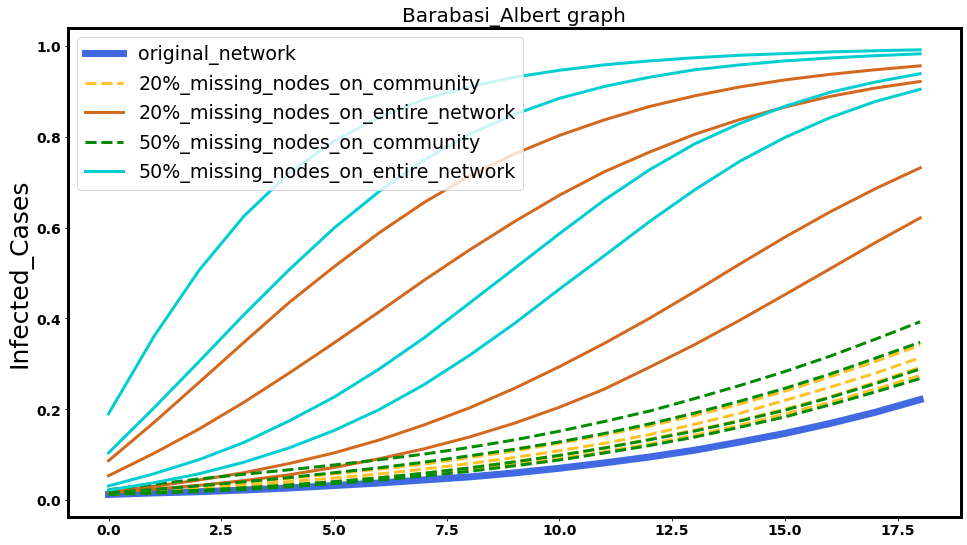

In [171]:
fig, ax = plt.subplots(1,1,figsize=(16,9))



plt.plot(dfe.index, dfe_mean,c='royalblue',label='original_network',linewidth=7.0)
#plt.fill_between(df.index, df_min, df_max, color='blue', alpha=.2)

plt.plot(df_c1_20.index, df_c1_20_mean,c='#FFC125',linestyle='--',label='20%_missing_nodes_on_community',linewidth=3.0)
#plt.fill_between(df_un10_com1.index, df_un10_com1_min, df_un10_com1_max, color='goldenrod', alpha=.2)
plt.plot(df_c2_20.index, df_c2_20_mean,c='#FFC125',linestyle='--',linewidth=3.0)
#plt.fill_between(df_un10_entire.index, df_un10_entire_min, df_un10_entire_max, color='chocolate', alpha=.2)
plt.plot(df_c3_20.index, df_c3_20_mean,c='#FFC125',linestyle='--',linewidth=3.0)
#plt.fill_between(df_un50_com1.index, df_un50_com1_min, df_un50_com1_max, color='lightskyblue', alpha=.2)
plt.plot(df_c4_20.index, df_c4_20_mean,c='#FFC125',linestyle='--',linewidth=3.0)
#plt.fill_between(df_un50_entire.index, df_un50_entire_min, df_un50_entire_max, color='mediumseagreen', alpha=.2)

plt.plot(df_e1_20.index, df_e1_20_mean,c='chocolate',label='20%_missing_nodes_on_entire_network',linewidth=3.0)
#plt.fill_between(df_un10_com1.index, df_un10_com1_min, df_un10_com1_max, color='goldenrod', alpha=.2)
plt.plot(df_e2_20.index, df_e2_20_mean,c='chocolate',linewidth=3.0)
#plt.fill_between(df_un10_entire.index, df_un10_entire_min, df_un10_entire_max, color='chocolate', alpha=.2)
plt.plot(df_e3_20.index, df_e3_20_mean,c='chocolate',linewidth=3.0)
#plt.fill_between(df_un50_com1.index, df_un50_com1_min, df_un50_com1_max, color='lightskyblue', alpha=.2)
plt.plot(df_e4_20.index, df_e4_20_mean,c='chocolate',linewidth=3.0)
#plt.fill_between(df_un50_entire.index, df_un50_entire_min, df_un50_entire_max, color='mediumseagreen', alpha=.2)


plt.plot(df_c1_50.index, df_c1_50_mean,c='#008B00',linestyle='--',label='50%_missing_nodes_on_community',linewidth=3.0)
#plt.fill_between(df_un10_com1.index, df_un10_com1_min, df_un10_com1_max, color='goldenrod', alpha=.2)
plt.plot(df_c2_50.index, df_c2_50_mean,c='#008B00',linestyle='--',linewidth=3.0)
#plt.fill_between(df_un10_entire.index, df_un10_entire_min, df_un10_entire_max, color='chocolate', alpha=.2)
plt.plot(df_c3_50.index, df_c3_50_mean,c='#008B00',linestyle='--',linewidth=3.0)
#plt.fill_between(df_un50_com1.index, df_un50_com1_min, df_un50_com1_max, color='lightskyblue', alpha=.2)
plt.plot(df_c4_50.index, df_c4_50_mean,c='#008B00',linestyle='--',linewidth=3.0)
#plt.fill_between(df_un50_entire.index, df_un50_entire_min, df_un50_entire_max, color='mediumseagreen', alpha=.2)

plt.plot(df_e1_50.index, df_e1_50_mean,c='darkturquoise',label='50%_missing_nodes_on_entire_network',linewidth=3.0)
#plt.fill_between(df_un10_com1.index, df_un10_com1_min, df_un10_com1_max, color='goldenrod', alpha=.2)
plt.plot(df_e2_50.index, df_e2_50_mean,c='darkturquoise',linewidth=3.0)
#plt.fill_between(df_un10_entire.index, df_un10_entire_min, df_un10_entire_max, color='chocolate', alpha=.2)
plt.plot(df_e3_50.index, df_e3_50_mean,c='darkturquoise',linewidth=3.0)
#plt.fill_between(df_un50_com1.index, df_un50_com1_min, df_un50_com1_max, color='lightskyblue', alpha=.2)
plt.plot(df_e4_50.index, df_e4_50_mean,c='darkturquoise',linewidth=3.0)
#plt.fill_between(df_un50_entire.index, df_un50_entire_min, df_un50_entire_max, color='mediumseagreen', alpha=.2)





fontsize = 14

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.rc('axes', linewidth=3)
#plt.ylim(0,0.35)
plt.xlabel('')
plt.ylabel('Infected_Cases',fontsize=25)
plt.title('Barabasi_Albert graph',fontsize=20)
plt.legend(fontsize=19)
#plt.xlim(0,20)
plt.savefig('MN_Watt_20-50com_SI0.001_5-10-10-100%number_infected.pdf')


In [254]:
#missing nodes on Erdos_Reny
G_Reny=nx.read_gpickle('G_Reny.gpickle')
IN_IN_Reny_com1=[138, 232, 352, 456, 194]


com_G_Reny={0: 0,
 1: 1,
 2: 2,
 3: 2,
 4: 3,
 5: 1,
 6: 4,
 7: 0,
 8: 4,
 9: 4,
 10: 2,
 11: 5,
 12: 6,
 13: 1,
 14: 1,
 15: 7,
 16: 3,
 17: 8,
 18: 2,
 19: 2,
 20: 6,
 21: 4,
 22: 8,
 23: 0,
 24: 9,
 25: 4,
 26: 8,
 27: 10,
 28: 0,
 29: 7,
 30: 1,
 31: 4,
 32: 1,
 33: 4,
 34: 3,
 35: 9,
 36: 0,
 37: 4,
 38: 1,
 39: 9,
 40: 3,
 41: 2,
 42: 5,
 43: 4,
 44: 7,
 45: 2,
 46: 6,
 47: 2,
 48: 1,
 49: 5,
 50: 8,
 51: 6,
 52: 10,
 53: 6,
 54: 10,
 55: 4,
 56: 0,
 57: 1,
 58: 0,
 59: 7,
 60: 4,
 61: 2,
 62: 1,
 63: 1,
 64: 3,
 65: 9,
 66: 9,
 67: 6,
 68: 9,
 69: 7,
 70: 0,
 71: 7,
 72: 6,
 73: 6,
 74: 2,
 75: 0,
 76: 0,
 77: 8,
 78: 4,
 79: 4,
 80: 9,
 81: 3,
 82: 5,
 83: 0,
 84: 0,
 85: 10,
 86: 3,
 87: 3,
 88: 8,
 89: 4,
 90: 1,
 91: 2,
 92: 7,
 93: 0,
 94: 0,
 95: 9,
 96: 9,
 97: 6,
 98: 0,
 99: 1,
 100: 2,
 101: 0,
 102: 9,
 103: 10,
 104: 6,
 105: 9,
 106: 6,
 107: 3,
 108: 2,
 109: 7,
 110: 0,
 111: 5,
 112: 3,
 113: 5,
 114: 4,
 115: 9,
 116: 10,
 117: 7,
 118: 2,
 119: 0,
 120: 4,
 121: 3,
 122: 5,
 123: 9,
 124: 6,
 125: 1,
 126: 7,
 127: 5,
 128: 5,
 129: 9,
 130: 6,
 131: 6,
 132: 1,
 133: 4,
 134: 6,
 135: 2,
 136: 4,
 137: 2,
 138: 4,
 139: 4,
 140: 3,
 141: 1,
 142: 8,
 143: 6,
 144: 3,
 145: 0,
 146: 3,
 147: 8,
 148: 4,
 149: 6,
 150: 3,
 151: 9,
 152: 9,
 153: 0,
 154: 9,
 155: 1,
 156: 6,
 157: 2,
 158: 10,
 159: 0,
 160: 2,
 161: 9,
 162: 3,
 163: 5,
 164: 9,
 165: 8,
 166: 4,
 167: 2,
 168: 0,
 169: 3,
 170: 3,
 171: 10,
 172: 4,
 173: 9,
 174: 9,
 175: 3,
 176: 10,
 177: 7,
 178: 3,
 179: 8,
 180: 10,
 181: 7,
 182: 10,
 183: 7,
 184: 9,
 185: 4,
 186: 9,
 187: 1,
 188: 10,
 189: 0,
 190: 5,
 191: 4,
 192: 6,
 193: 10,
 194: 4,
 195: 3,
 196: 7,
 197: 5,
 198: 0,
 199: 4,
 200: 7,
 201: 6,
 202: 10,
 203: 4,
 204: 3,
 205: 9,
 206: 6,
 207: 2,
 208: 3,
 209: 1,
 210: 4,
 211: 7,
 212: 10,
 213: 8,
 214: 3,
 215: 7,
 216: 9,
 217: 9,
 218: 0,
 219: 0,
 220: 4,
 221: 3,
 222: 0,
 223: 4,
 224: 1,
 225: 9,
 226: 1,
 227: 2,
 228: 4,
 229: 9,
 230: 3,
 231: 5,
 232: 4,
 233: 9,
 234: 5,
 235: 7,
 236: 2,
 237: 7,
 238: 8,
 239: 5,
 240: 8,
 241: 7,
 242: 5,
 243: 5,
 244: 5,
 245: 8,
 246: 5,
 247: 6,
 248: 3,
 249: 6,
 250: 4,
 251: 2,
 252: 9,
 253: 0,
 254: 0,
 255: 7,
 256: 4,
 257: 4,
 258: 6,
 259: 4,
 260: 4,
 261: 3,
 262: 5,
 263: 2,
 264: 6,
 265: 2,
 266: 0,
 267: 0,
 268: 4,
 269: 0,
 270: 0,
 271: 4,
 272: 3,
 273: 6,
 274: 7,
 275: 1,
 276: 3,
 277: 9,
 278: 6,
 279: 3,
 280: 10,
 281: 9,
 282: 4,
 283: 6,
 284: 10,
 285: 9,
 286: 8,
 287: 5,
 288: 10,
 289: 2,
 290: 7,
 291: 3,
 292: 3,
 293: 7,
 294: 10,
 295: 0,
 296: 1,
 297: 4,
 298: 8,
 299: 1,
 300: 6,
 301: 7,
 302: 9,
 303: 10,
 304: 6,
 305: 10,
 306: 2,
 307: 6,
 308: 7,
 309: 7,
 310: 1,
 311: 10,
 312: 2,
 313: 9,
 314: 10,
 315: 2,
 316: 5,
 317: 9,
 318: 4,
 319: 8,
 320: 0,
 321: 1,
 322: 6,
 323: 6,
 324: 1,
 325: 0,
 326: 1,
 327: 5,
 328: 6,
 329: 4,
 330: 4,
 331: 0,
 332: 3,
 333: 0,
 334: 2,
 335: 3,
 336: 6,
 337: 4,
 338: 1,
 339: 6,
 340: 6,
 341: 6,
 342: 4,
 343: 6,
 344: 3,
 345: 6,
 346: 3,
 347: 3,
 348: 9,
 349: 0,
 350: 0,
 351: 6,
 352: 4,
 353: 4,
 354: 0,
 355: 7,
 356: 1,
 357: 8,
 358: 4,
 359: 5,
 360: 3,
 361: 2,
 362: 7,
 363: 0,
 364: 5,
 365: 3,
 366: 6,
 367: 9,
 368: 8,
 369: 6,
 370: 4,
 371: 1,
 372: 4,
 373: 0,
 374: 8,
 375: 6,
 376: 8,
 377: 8,
 378: 9,
 379: 4,
 380: 6,
 381: 1,
 382: 7,
 383: 7,
 384: 4,
 385: 4,
 386: 4,
 387: 0,
 388: 2,
 389: 7,
 390: 4,
 391: 3,
 392: 6,
 393: 0,
 394: 6,
 395: 8,
 396: 9,
 397: 1,
 398: 9,
 399: 10,
 400: 1,
 401: 4,
 402: 9,
 403: 4,
 404: 9,
 405: 6,
 406: 0,
 407: 9,
 408: 7,
 409: 6,
 410: 4,
 411: 6,
 412: 10,
 413: 9,
 414: 9,
 415: 10,
 416: 5,
 417: 10,
 418: 2,
 419: 2,
 420: 6,
 421: 3,
 422: 9,
 423: 0,
 424: 7,
 425: 6,
 426: 3,
 427: 9,
 428: 9,
 429: 1,
 430: 3,
 431: 10,
 432: 4,
 433: 6,
 434: 2,
 435: 4,
 436: 0,
 437: 8,
 438: 4,
 439: 1,
 440: 6,
 441: 10,
 442: 4,
 443: 0,
 444: 9,
 445: 1,
 446: 3,
 447: 8,
 448: 2,
 449: 1,
 450: 6,
 451: 2,
 452: 0,
 453: 8,
 454: 6,
 455: 4,
 456: 4,
 457: 2,
 458: 3,
 459: 9,
 460: 6,
 461: 9,
 462: 2,
 463: 3,
 464: 6,
 465: 1,
 466: 10,
 467: 4,
 468: 4,
 469: 10,
 470: 0,
 471: 3,
 472: 1,
 473: 4,
 474: 0,
 475: 4,
 476: 5,
 477: 2,
 478: 2,
 479: 4,
 480: 8,
 481: 2,
 482: 7,
 483: 10,
 484: 2,
 485: 8,
 486: 4,
 487: 5,
 488: 4,
 489: 9,
 490: 8,
 491: 6,
 492: 5,
 493: 2,
 494: 6,
 495: 2,
 496: 5,
 497: 2,
 498: 3,
 499: 0}

Reny_com_dam_error=make_list_node_com(com_G_Reny,4)
Reny_com_4=[]
for item in Reny_com_dam_error:
    Reny_com_4.append(str(item))

    
    #make missing node networks
initial_nodes_Reny=list(G_Reny.nodes())

# make just one network with a certain number of new missing nodes
#then we want to analyse how much of this missing node should be initial infected until the epidemic behaviour of original network change
#so we need one add miss node to entire and one to comunity but we need different set of initial infected nodes
#we assess just the infected cases of the initial nodes
 #for entire network 20%/50% number of totall nodes
MN_Reny_20, list_MN_entire_20=add_uncertainty_node_entire_network_Reny(G_Reny,20)
MN_Reny_com_20, list_MN_com_20=add_uncertainty_node_comunity_Reny(G_Reny,Reny_com_4,20)
MN_Reny_50, list_MN_entire_50=add_uncertainty_node_entire_network_Reny(G_Reny,50)
MN_Reny_com_50, list_MN_com_50=add_uncertainty_node_comunity_Reny(G_Reny,Reny_com_4,50)


In [256]:
#make initial infected nodes from the node set that was added to the network as missing node
#5 different initial infected nodes. we increase the number of missing nodes in initial infected set
#Initial infected set for original network
IN_IN_Reny1=IN_IN_Reny_com1
#Initial infected set for network with 20 % extra missing nodes added to entire network (20% number of node in entire network)
IN_IN_Reny_20_c1=IN_IN_Reny_com1+list(random.sample(list_MN_com_20, int(0.05*len(list_MN_com_20))))
IN_IN_Reny_20_c2=IN_IN_Reny_com1+list(random.sample(list_MN_com_20, int(0.1*len(list_MN_com_20))))
IN_IN_Reny_20_c3=IN_IN_Reny_com1+list(random.sample(list_MN_com_20, int(0.5*len(list_MN_com_20))))
IN_IN_Reny_20_c4=IN_IN_Reny_com1+list_MN_com_20
#Initial infected set for network with 20 % extra missing nodes added to comunity (20% number of node in entire network)
IN_IN_Reny2_20=IN_IN_Reny_com1+list(random.sample(list_MN_entire_20, int(0.05*len(list_MN_entire_20))))
IN_IN_Reny3_20=IN_IN_Reny_com1+list(random.sample(list_MN_entire_20, int(0.1*len(list_MN_entire_20))))
IN_IN_Reny4_20=IN_IN_Reny_com1+list(random.sample(list_MN_entire_20, int(0.5*len(list_MN_entire_20))))
IN_IN_Reny5_20=IN_IN_Reny_com1+list_MN_entire_20


#Initial infected set for network with 50 % extra missing nodes added to entire network (20% number of node in entire network)
IN_IN_Reny_50_c1=IN_IN_Reny_com1+list(random.sample(list_MN_com_50, int(0.05*len(list_MN_com_50))))
IN_IN_Reny_50_c2=IN_IN_Reny_com1+list(random.sample(list_MN_com_50, int(0.1*len(list_MN_com_50))))
IN_IN_Reny_50_c3=IN_IN_Reny_com1+list(random.sample(list_MN_com_50, int(0.5*len(list_MN_com_50))))
IN_IN_Reny_50_c4=IN_IN_Reny_com1+list_MN_com_50
#Initial infected set for network with 50 % extra missing nodes added to comunity (20% number of node in entire network)
IN_IN_Reny2_50=IN_IN_Reny_com1+list(random.sample(list_MN_entire_50, int(0.05*len(list_MN_entire_50))))
IN_IN_Reny3_50=IN_IN_Reny_com1+list(random.sample(list_MN_entire_50, int(0.1*len(list_MN_entire_50))))
IN_IN_Reny4_50=IN_IN_Reny_com1+list(random.sample(list_MN_entire_50, int(0.5*len(list_MN_entire_50))))
IN_IN_Reny5_50=IN_IN_Reny_com1+list_MN_entire_50

In [271]:
#new assumtion
#original network
dfe, dfe_mean, dfe_min, dfe_max=multiran_result_SI_missing_node(G_Reny,initial_nodes_Reny,IN_IN_Reny1)

#increasing number of initial infected nodes which are in missing node set. number of missing nodes is 20% of total number of nodes in entire network 
df_e1_20, df_e1_20_mean, df_e1_20_min,df_e1_20_max=multiran_result_SI_missing_node(MN_Reny_20,initial_nodes_Reny,IN_IN_Reny2_20)
df_e2_20, df_e2_20_mean, df_e2_20_min,df_e2_20_max=multiran_result_SI_missing_node(MN_Reny_20,initial_nodes_Reny,IN_IN_Reny3_20)
df_e3_20, df_e3_20_mean, df_e3_20_min,df_e3_20_max=multiran_result_SI_missing_node(MN_Reny_20,initial_nodes_Reny,IN_IN_Reny4_20)
df_e4_20, df_e4_20_mean, df_e4_20_min,df_e4_20_max=multiran_result_SI_missing_node(MN_Reny_20,initial_nodes_Reny,IN_IN_Reny5_20)

#increasing number of initial infected nodes which are in missing node set. number of missing nodes is 0% of total number of nodes in comunity 
#dfc, dfc_mean, dfc_min, dfc_max=multiran_result_SI_missing_node(G_Bar,initial_nodes_Bar,IN_IN_Bar1)
df_c1_20, df_c1_20_mean, df_c1_20_min,df_c1_20_max=multiran_result_SI_missing_node(MN_Reny_com_20,initial_nodes_Reny,IN_IN_Reny_20_c1)
df_c2_20, df_c2_20_mean, df_c2_20_min,df_c2_20_max=multiran_result_SI_missing_node(MN_Reny_com_20,initial_nodes_Reny,IN_IN_Reny_20_c2)
df_c3_20, df_c3_20_mean, df_c3_20_min,df_c3_20_max=multiran_result_SI_missing_node(MN_Reny_com_20,initial_nodes_Reny,IN_IN_Reny_20_c3)
df_c4_20, df_c4_20_mean, df_c4_20_min,df_c4_20_max=multiran_result_SI_missing_node(MN_Reny_com_20,initial_nodes_Reny,IN_IN_Reny_20_c4)


#increasing number of initial infected nodes which are in missing node set. number of missing nodes is 50% of total number of nodes in entire network 
df_e1_50, df_e1_50_mean, df_e1_50_min,df_e1_50_max=multiran_result_SI_missing_node(MN_Reny_50,initial_nodes_Reny,IN_IN_Reny2_50)
df_e2_50, df_e2_50_mean, df_e2_50_min,df_e2_50_max=multiran_result_SI_missing_node(MN_Reny_50,initial_nodes_Reny,IN_IN_Reny3_50)
df_e3_50, df_e3_50_mean, df_e3_50_min,df_e3_50_max=multiran_result_SI_missing_node(MN_Reny_50,initial_nodes_Reny,IN_IN_Reny4_50)
df_e4_50, df_e4_50_mean, df_e4_50_min,df_e4_50_max=multiran_result_SI_missing_node(MN_Reny_50,initial_nodes_Reny,IN_IN_Reny5_50)

#increasing number of initial infected nodes which are in missing node set. number of missing nodes is 50% of total number of nodes in comunity 
df_c1_50, df_c1_50_mean, df_c1_50_min,df_c1_50_max=multiran_result_SI_missing_node(MN_Reny_com_50,initial_nodes_Reny,IN_IN_Reny_50_c1)
df_c2_50, df_c2_50_mean, df_c2_50_min,df_c2_50_max=multiran_result_SI_missing_node(MN_Reny_com_50,initial_nodes_Reny,IN_IN_Reny_50_c2)
df_c3_50, df_c3_50_mean, df_c3_50_min,df_c3_50_max=multiran_result_SI_missing_node(MN_Reny_com_50,initial_nodes_Reny,IN_IN_Reny_50_c3)
df_c4_50, df_c4_50_mean, df_c4_50_min,df_c4_50_max=multiran_result_SI_missing_node(MN_Reny_com_50,initial_nodes_Reny,IN_IN_Reny_50_c4)

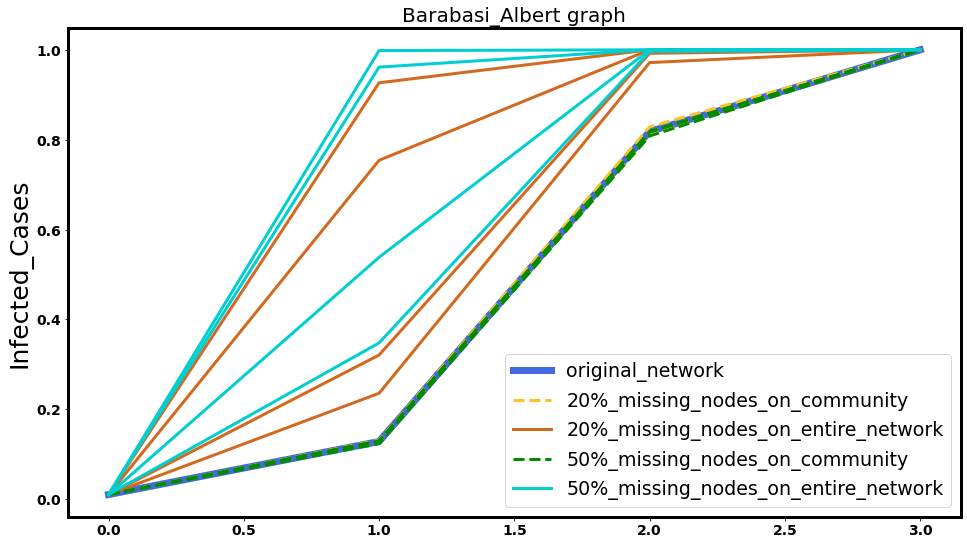

In [272]:
fig, ax = plt.subplots(1,1,figsize=(16,9))



plt.plot(dfe.index, dfe_mean,c='royalblue',label='original_network',linewidth=7.0)
#plt.fill_between(df.index, df_min, df_max, color='blue', alpha=.2)

plt.plot(df_c1_20.index, df_c1_20_mean,c='#FFC125',linestyle='--',label='20%_missing_nodes_on_community',linewidth=3.0)
#plt.fill_between(df_un10_com1.index, df_un10_com1_min, df_un10_com1_max, color='goldenrod', alpha=.2)
plt.plot(df_c2_20.index, df_c2_20_mean,c='#FFC125',linestyle='--',linewidth=3.0)
#plt.fill_between(df_un10_entire.index, df_un10_entire_min, df_un10_entire_max, color='chocolate', alpha=.2)
plt.plot(df_c3_20.index, df_c3_20_mean,c='#FFC125',linestyle='--',linewidth=3.0)
#plt.fill_between(df_un50_com1.index, df_un50_com1_min, df_un50_com1_max, color='lightskyblue', alpha=.2)
plt.plot(df_c4_20.index, df_c4_20_mean,c='#FFC125',linestyle='--',linewidth=3.0)
#plt.fill_between(df_un50_entire.index, df_un50_entire_min, df_un50_entire_max, color='mediumseagreen', alpha=.2)

plt.plot(df_e1_20.index, df_e1_20_mean,c='chocolate',label='20%_missing_nodes_on_entire_network',linewidth=3.0)
#plt.fill_between(df_un10_com1.index, df_un10_com1_min, df_un10_com1_max, color='goldenrod', alpha=.2)
plt.plot(df_e2_20.index, df_e2_20_mean,c='chocolate',linewidth=3.0)
#plt.fill_between(df_un10_entire.index, df_un10_entire_min, df_un10_entire_max, color='chocolate', alpha=.2)
plt.plot(df_e3_20.index, df_e3_20_mean,c='chocolate',linewidth=3.0)
#plt.fill_between(df_un50_com1.index, df_un50_com1_min, df_un50_com1_max, color='lightskyblue', alpha=.2)
plt.plot(df_e4_20.index, df_e4_20_mean,c='chocolate',linewidth=3.0)
#plt.fill_between(df_un50_entire.index, df_un50_entire_min, df_un50_entire_max, color='mediumseagreen', alpha=.2)


plt.plot(df_c1_50.index, df_c1_50_mean,c='#008B00',linestyle='--',label='50%_missing_nodes_on_community',linewidth=3.0)
#plt.fill_between(df_un10_com1.index, df_un10_com1_min, df_un10_com1_max, color='goldenrod', alpha=.2)
plt.plot(df_c2_50.index, df_c2_50_mean,c='#008B00',linestyle='--',linewidth=3.0)
#plt.fill_between(df_un10_entire.index, df_un10_entire_min, df_un10_entire_max, color='chocolate', alpha=.2)
plt.plot(df_c3_50.index, df_c3_50_mean,c='#008B00',linestyle='--',linewidth=3.0)
#plt.fill_between(df_un50_com1.index, df_un50_com1_min, df_un50_com1_max, color='lightskyblue', alpha=.2)
plt.plot(df_c4_50.index, df_c4_50_mean,c='#008B00',linestyle='--',linewidth=3.0)
#plt.fill_between(df_un50_entire.index, df_un50_entire_min, df_un50_entire_max, color='mediumseagreen', alpha=.2)

plt.plot(df_e1_50.index, df_e1_50_mean,c='darkturquoise',label='50%_missing_nodes_on_entire_network',linewidth=3.0)
#plt.fill_between(df_un10_com1.index, df_un10_com1_min, df_un10_com1_max, color='goldenrod', alpha=.2)
plt.plot(df_e2_50.index, df_e2_50_mean,c='darkturquoise',linewidth=3.0)
#plt.fill_between(df_un10_entire.index, df_un10_entire_min, df_un10_entire_max, color='chocolate', alpha=.2)
plt.plot(df_e3_50.index, df_e3_50_mean,c='darkturquoise',linewidth=3.0)
#plt.fill_between(df_un50_com1.index, df_un50_com1_min, df_un50_com1_max, color='lightskyblue', alpha=.2)
plt.plot(df_e4_50.index, df_e4_50_mean,c='darkturquoise',linewidth=3.0)
#plt.fill_between(df_un50_entire.index, df_un50_entire_min, df_un50_entire_max, color='mediumseagreen', alpha=.2)





fontsize = 14

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.rc('axes', linewidth=3)
#plt.ylim(0,0.35)
plt.xlabel('')
plt.ylabel('Infected_Cases',fontsize=25)
plt.title('Barabasi_Albert graph',fontsize=20)
plt.legend(fontsize=19)
#plt.xlim(0,20)
plt.savefig('MN_Reny_20-50com_SI0.001_5-10-10-100%number_infected.pdf')


# plot of incidence after a constant number of step for different number of missing nodes added and assumed as initial infected


In [12]:
#make a plot for number of infected cases(incidence) after n step(for example n=2) for different number of missing nodes. 
#it means add 1 missing node to the network, assume that one missing node initial infected, run epidemic, find number of infected case after an n arbitrary steps. 
#add 2 missing nodes to the network, assume that one missing node initial infected, run epidemic, find number of infected case after an n arbitrary steps.
#repeat it untim m missing nodes


from statistics import mean
#new function to add certain m missing node to the network
            
def add_m_missing_nodes_entire_comunity_Bar(graph,list_n,N_MN): #here we add N_MN missing nodes to entire and comunity seperately
    degree=5
    G_original=graph.copy()                                                
    G_MN_entire=copy.deepcopy(graph)
    G_MN_com=copy.deepcopy(graph)
    N_missing_nodes=N_MN
    dic_degree=dict(G_original.degree(weight='weight'))
    sum_degree=sum(dic_degree.values())
    
    list_missing_node=[]
    for j in range(N_missing_nodes):
        m=0
        node_name='Miss'+str(j)
        list_missing_node.append(node_name)
        G_MN_entire.add_node(node_name)
        G_MN_com.add_node(node_name)
         #random shuffle does not return any list. random shuffle changes the order of nodes in the original list 
        list_original_node=list(G_original.nodes())
        list_com_node=list_n.copy()
        random.shuffle(list_original_node)
        random.shuffle(list_com_node)
        for node1 in list_original_node:
            if m==degree:
                break
            else:
                k=G_original.degree(node1, weight='weight')
                p=float(k/sum_degree)
                if random.random()<p:
                    w=random.randint(1, 50)
                    G_MN_entire.add_edge(node_name,node1,weight=w)
                    m+=1
        for node1 in list_com_node:
            if m==degree:
                break
            else:
                k=G_original.degree(node1, weight='weight')
                p=float(k/sum_degree)
                if random.random()<p:
                    w=random.randint(1, 50)
                    G_MN_com.add_edge(node_name,node1,weight=w)
                    m+=1
    return G_MN_entire ,G_MN_com, list_missing_node


def add_m_missing_nodes_entire_comunity_Reny(graph,list_n,N_MN): #here we add N_MN missing nodes to entire and comunity seperately
    p=0.5
    G_original=graph.copy()                                                
    G_MN_entire=copy.deepcopy(graph)
    G_MN_com=copy.deepcopy(graph)
    N_missing_nodes=N_MN
    list_original_node=list(G_original.nodes())
    list_com_node=list_n.copy()

    
    list_missing_node=[]
    for j in range(N_missing_nodes):
        node_name='Miss'+str(j)
        list_missing_node.append(node_name)
        G_MN_entire.add_node(node_name)
        G_MN_com.add_node(node_name)
         #random shuffle does not return any list. random shuffle changes the order of nodes in the original list 
        
        for node1 in list_original_node:
            if random.random()<p:
                    #assumption on weights I assumed for constructing the original erdos reny network
                w_m=np.random.choice(np.arange(1, 11), p=[0.8, 0.04, 0.02, 0.02, 0.02, 0.02,0.02,0.02,0.02,0.02]) #int(1.64 * np.random.randn() + 1.53) # this distribution can give 0 or negative value which is not suitable for my code
                w_a=random.randint(1, 50)                            
                w=w_m*w_a
                G_MN_entire.add_edge(node_name,node1,weight=w)
                    
        for node1 in list_com_node:
             if random.random()<p:
                    #assumption on weights I assumed for constructing the original erdos reny network
                w_m=np.random.choice(np.arange(1, 11), p=[0.8, 0.04, 0.02, 0.02, 0.02, 0.02,0.02,0.02,0.02,0.02]) #int(1.64 * np.random.randn() + 1.53) # this distribution can give 0 or negative value which is not suitable for my code
                w_a=random.randint(1, 50)                            
                w=w_m*w_a
                G_MN_com.add_edge(node_name,node1,weight=w)

    return G_MN_entire ,G_MN_com, list_missing_node

#new function for epidemic. returning number of infected cases in original network after k step
def Epi_SI_for_missing_node_afte_i_step(Graph,initial_nodes, initial_infecteds, i): #i is number of steps that program is run
    G=copy.deepcopy(Graph)
    beta=0.001#0.00134228   #0.001121#0.002242           # weight_un=#0.00095969#0.00191938 #0.00136986# previous: 0.0027397
    infected = initial_infecteds.copy()
    N=len(initial_nodes)
    #number of steps of iteration
    susceptible = list(G.nodes())
    
    for infected_node in infected:
        if infected_node in susceptible: 
            susceptible.remove(infected_node)
    initial_infected_Initial_node_set=[]
    for n in infected:
        if n in initial_nodes:
            initial_infected_Initial_node_set.append(n)
    num_infected_results=[]
    num_infected_results.append(float(len(initial_infected_Initial_node_set)/N))
    num_j=[]
    num_j.append([0,float(len(initial_infected_Initial_node_set)/N)])
    infected_Initial_node_set=[]
    #Inicializar el tiempo
    t = 0
    j=1
    while j<i+1:
        infected_1 = list()
        #Realizar la infección
        for node in infected: 
            if len(set(G.neighbors(node)))>0:
                '''strategy here is that every time the first chance is get to the highest weight of edges in node neighbors. 
                if rhe neighbor with highest weight does not infect then the second chance is based on random sample choice'''
                edges = list(G.edges(node, data=True))
                if len(edges)==1:
                    neigh=edges[0][1]
                    #neigh=set(G.neighbors(node))
                    if  neigh not in list(infected):
                        if  neigh not in list(infected_1):
                            if random.random()<beta*G[node][neigh]['weight']:
                                infected_1.append(neigh)
                # if len(edges) > 0: #some nodes have zero edges going into it #this one could be useful in directed network
                else:
                    for nbr in set(G.neighbors(node)):
                        if nbr not in list(infected):
                            if  nbr not in list(infected_1):
                                if random.random()<beta*G[node][nbr]['weight']:
                                    infected_1.append(nbr)
        #Remover a los infectados de los susceptibles:
        infected += infected_1
        for infected_node in infected_1:
            if infected_node in susceptible: 
                susceptible.remove(infected_node)
            

        #Registrar el porcentaje de nodos infectados en una lista para luego graficar
        for n in infected:
            if n in initial_nodes:
                if n not in infected_Initial_node_set:
                    infected_Initial_node_set.append(n)
        num_infected_results.append(float(len(infected_Initial_node_set)/N))
        num_j.append([j,float(len(infected)/N)])
        
        #Actualizar el tiempo
        j +=1
                            
    return num_infected_results[-1]

def multiran_result_SI_missing_node_after_i_step(Graph,initial_nodes,IN_IN, n_step ):
    I_list=[]
    for i in range(1,11):
        I_n=Epi_SI_for_missing_node_afte_i_step(Graph,initial_nodes,IN_IN, n_step)
        I_list.append(I_n) 
    mean_val_un = mean(I_list)
    
    return mean_val_un

#for Barabashi_Albert network
def add_initial_infected_MN_Bar(Graph,list_n, N_step):
    initial_nodes=list(Graph.nodes())
    G_Bar=copy.deepcopy(Graph)
    #final amount of missing nodes
    MN_final_amount=500
    Number_infected_addMNentire=[]
    Number_infected_addMNcom=[]
    #adding missing links one by one and make the network and run the epidemic
    for i in range(1,MN_final_amount+1):
        G_entire,G_com, list_MN=add_m_missing_nodes_entire_comunity_Bar(G_Bar,list_n,i)
        Initial_Infected_nodes=list_MN
        mean_addMNentire =multiran_result_SI_missing_node_after_i_step(G_entire,initial_nodes,Initial_Infected_nodes, N_step)
        mean_addMNcom=multiran_result_SI_missing_node_after_i_step(G_com,initial_nodes,Initial_Infected_nodes, N_step)
        Number_infected_addMNentire.append(mean_addMNentire)
        Number_infected_addMNcom.append(mean_addMNcom)
        
    Number_addMN=list(range(1,MN_final_amount+1))   
    return Number_infected_addMNentire, Number_infected_addMNcom, Number_addMN 

#for Erdos_Reny network
def add_initial_infected_MN_Reny(Graph,list_n, N_step):
    initial_nodes=list(Graph.nodes())
    G_Reny=copy.deepcopy(Graph)
    #final amount of missing nodes
    MN_final_amount=500
    Number_infected_addMNentire=[]
    Number_infected_addMNcom=[]
    #adding missing links one by one and make the network and run the epidemic
    for i in range(1,MN_final_amount+1):
        G_entire,G_com, list_MN=add_m_missing_nodes_entire_comunity_Reny(G_Reny,list_n,i)
        Initial_Infected_nodes=list_MN
        mean_addMNentire =multiran_result_SI_missing_node_after_i_step(G_entire,initial_nodes,Initial_Infected_nodes, N_step)
        mean_addMNcom=multiran_result_SI_missing_node_after_i_step(G_com,initial_nodes,Initial_Infected_nodes, N_step)
        Number_infected_addMNentire.append(mean_addMNentire)
        Number_infected_addMNcom.append(mean_addMNcom)
        
    Number_addMN=list(range(1,MN_final_amount+1))   
    return Number_infected_addMNentire, Number_infected_addMNcom, Number_addMN 

In [229]:

I_entire_1_step,I_com_1_step,N_MN_add=add_initial_infected_MN_Bar(G_Bar,Bar_com_1,1)
I_entire_2_step,I_com_2_step,N_MN_add=add_initial_infected_MN_Bar(G_Bar,Bar_com_1,2)
I_entire_3_step,I_com_3_step,N_MN_add=add_initial_infected_MN_Bar(G_Bar,Bar_com_1,3)
I_entire_4_step,I_com_4_step,N_MN_add=add_initial_infected_MN_Bar(G_Bar,Bar_com_1,4)
I_entire_5_step,I_com_5_step,N_MN_add=add_initial_infected_MN_Bar(G_Bar,Bar_com_1,5)

#plot
#plot
fig, ax = plt.subplots(1,1,figsize=(16,9))


plt.plot(N_MN_add, I_com_1_step,c='#384B3A',linestyle='dotted',label='1 step_comunity',linewidth=3.0)
plt.plot(N_MN_add, I_entire_1_step,c='#384B3A',label='1 step_entire_network',linewidth=3.0)

plt.plot(N_MN_add, I_com_2_step,c='#385062',linestyle='dotted',label='2 steps_comunity',linewidth=3.0)
plt.plot(N_MN_add, I_entire_2_step,c='#385062',label='2 steps_entire_network',linewidth=3.0)

plt.plot(N_MN_add, I_com_3_step,c='#71543C',linestyle='dotted',label='3 steps_comunity',linewidth=3.0)
plt.plot(N_MN_add, I_entire_3_step,c='#71543C',label='3 steps_entire_network',linewidth=3.0)

plt.plot(N_MN_add, I_com_4_step,c='#C0522B',linestyle='dotted',label='4 steps_comunity',linewidth=3.0)
plt.plot(N_MN_add, I_entire_4_step,c='#C0522B',label='4 steps_entire_network',linewidth=3.0)


plt.plot(N_MN_add, I_com_5_step,linestyle='dotted',label='5 steps_comunity',c='#F78F32',linewidth=3.0)
plt.plot(N_MN_add, I_entire_5_step,label='5 steps_entire_network',c='#F78F32',linewidth=3.0)


fontsize = 14

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.rc('axes', linewidth=3)
plt.xlabel('Number of Missing nodes', fontsize=25)
plt.ylabel('Incidence',fontsize=25)
#plt.title('a',fontsize=20)
plt.legend(fontsize=19)
plt.savefig('Incidence-MN1-500_after1-5 steps.pdf')

ValueError: Invalid RGBA argument: '62A98C'

<Figure size 1152x648 with 1 Axes>

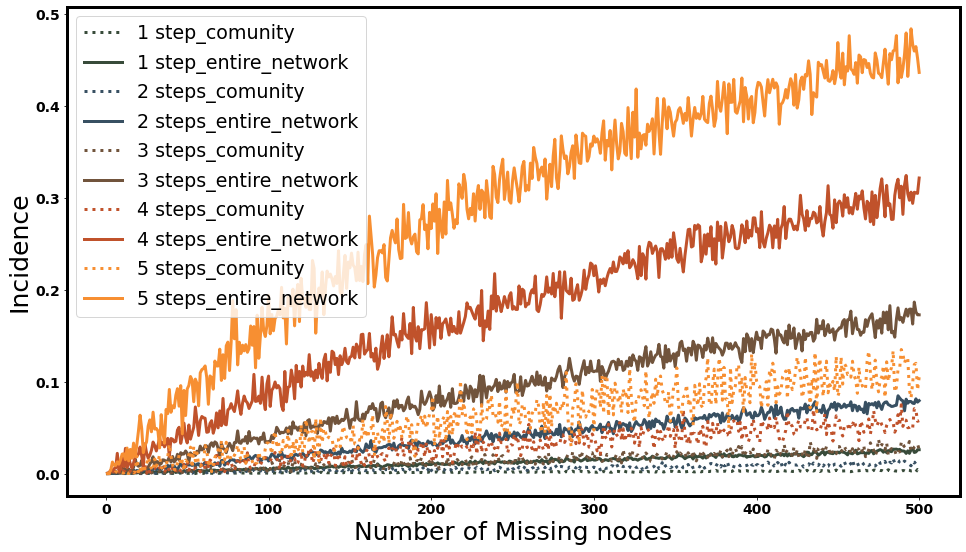

In [243]:
#plot
fig, ax = plt.subplots(1,1,figsize=(16,9))


plt.plot(N_MN_add, I_com_1_step,c='#384B3A',linestyle='dotted',label='1 step_comunity',linewidth=3.0)
plt.plot(N_MN_add, I_entire_1_step,c='#384B3A',label='1 step_entire_network',linewidth=3.0)

plt.plot(N_MN_add, I_com_2_step,c='#385062',linestyle='dotted',label='2 steps_comunity',linewidth=3.0)
plt.plot(N_MN_add, I_entire_2_step,c='#385062',label='2 steps_entire_network',linewidth=3.0)

plt.plot(N_MN_add, I_com_3_step,c='#71543C',linestyle='dotted',label='3 steps_comunity',linewidth=3.0)
plt.plot(N_MN_add, I_entire_3_step,c='#71543C',label='3 steps_entire_network',linewidth=3.0)

plt.plot(N_MN_add, I_com_4_step,c='#C0522B',linestyle='dotted',label='4 steps_comunity',linewidth=3.0)
plt.plot(N_MN_add, I_entire_4_step,c='#C0522B',label='4 steps_entire_network',linewidth=3.0)


plt.plot(N_MN_add, I_com_5_step,linestyle='dotted',label='5 steps_comunity',c='#F78F32',linewidth=3.0)
plt.plot(N_MN_add, I_entire_5_step,label='5 steps_entire_network',c='#F78F32',linewidth=3.0)


fontsize = 14

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.rc('axes', linewidth=3)
plt.xlabel('Number of Missing nodes', fontsize=25)
plt.ylabel('Incidence',fontsize=25)
#plt.title('a',fontsize=20)
plt.legend(fontsize=19)
plt.savefig('Incidence-MN1-500_after1-5 steps_Bar.pdf')

In [ ]:

I_entire_1_step,I_com_1_step,N_MN_add=add_initial_infected_MN_Reny(G_Reny,Reny_com_4,1)
I_entire_2_step,I_com_2_step,N_MN_add=add_initial_infected_MN_Reny(G_Reny,Reny_com_4,2)
I_entire_3_step,I_com_3_step,N_MN_add=add_initial_infected_MN_Reny(G_Reny,Reny_com_4,3)


#plot
#plot
fig, ax = plt.subplots(1,1,figsize=(16,9))


plt.plot(N_MN_add, I_com_1_step,c='#384B3A',linestyle='dotted',label='1 step_comunity',linewidth=3.0)
plt.plot(N_MN_add, I_entire_1_step,c='#384B3A',label='1 step_entire_network',linewidth=3.0)

plt.plot(N_MN_add, I_com_2_step,c='#385062',linestyle='dotted',label='2 steps_comunity',linewidth=3.0)
plt.plot(N_MN_add, I_entire_2_step,c='#385062',label='2 steps_entire_network',linewidth=3.0)

plt.plot(N_MN_add, I_com_3_step,c='#71543C',linestyle='dotted',label='3 steps_comunity',linewidth=3.0)
plt.plot(N_MN_add, I_entire_3_step,c='#71543C',label='3 steps_entire_network',linewidth=3.0)

#plt.plot(N_MN_add, I_com_4_step,c='#C0522B',linestyle='dotted',label='4 steps_comunity',linewidth=3.0)
#plt.plot(N_MN_add, I_entire_4_step,c='#C0522B',label='4 steps_entire_network',linewidth=3.0)


#plt.plot(N_MN_add, I_com_5_step,linestyle='dotted',label='5 steps_comunity',c='#F78F32',linewidth=3.0)
#plt.plot(N_MN_add, I_entire_5_step,label='5 steps_entire_network',c='#F78F32',linewidth=3.0)


fontsize = 14

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.rc('axes', linewidth=3)
plt.xlabel('Number of Missing nodes', fontsize=25)
plt.ylabel('Incidence',fontsize=25)
#plt.title('a',fontsize=20)
plt.legend(fontsize=19)
plt.savefig('Incidence-MN1-500_after1-5 steps_Reny.pdf')

In [ ]:
#trash_I will run missing nodes here because the notebook for real network in on run


In [16]:
import networkx as nx
import matplotlib.pyplot as plt 
import pandas as pd 
import feather as ft 
import random 
import numpy as np
import statistics
import copy 

df=ft.read_dataframe('table_all.feather')

dc_Meso_index= pd.read_excel('dc_Meso_index.xlsx').set_index('Mesoregion') 
center_list_code=list(dc_Meso_index.loc[['Central Mineira','Metropolitana de Belo Horizonte'],'city_code']) 
north_list_code=list(dc_Meso_index.loc[['Noroeste de Minas','Norte de Minas'],'city_code']) 
east_list_code=list(dc_Meso_index.loc[['Jequitinhonha','Vale do Mucuri','Vale do Rio Doce'],'city_code']) 
south_list_code=list(dc_Meso_index.loc[['Campo das Vertentes','Oeste de Minas','Sul/​Sudoeste de Minas','Zona da Mata'],'city_code']) 
west_list_code=list(dc_Meso_index.loc[['Triângulo Mineiro/​Alto Paranaiba'],'city_code'])

'''
df_city_code_latitude_longitude=pd.read_excel('df_city_code_latitude_longitude.xlsx',index_col=0)
list_municipality_code= df_city_code_latitude_longitude['municipality_code'].tolist()'''

"\ndf_city_code_latitude_longitude=pd.read_excel('df_city_code_latitude_longitude.xlsx',index_col=0)\nlist_municipality_code= df_city_code_latitude_longitude['municipality_code'].tolist()"

In [41]:
sample=df.iloc[:,[1,13,14,15,17,18,19,21,22,30,32]] #part of data that we need including

#remove importation exportation        
#remove importation exportation        
sample=sample.set_index('UF_de_Origem') 
sample=sample.loc[b'MG']
sample=sample.reset_index()
sample=sample.set_index('UF_de_Destino') 
sample=sample.loc[b'MG']
sample=sample.reset_index()


sample=sample.set_index('ano') 
sample=sample.loc[2013]
sample=sample.reset_index()

sample=sample[sample['MONTH']<7] #the first day of Jan and the first day of July for drawing network
sample=sample.reset_index()

#sample=sample.loc[sample['MONTH']<7] 
#sample=sample.reset_index()
 
origin_code=sample['Codigo_do_Local_de_Origem'] #all origins in dataset_include itterable name len(origin_code) is not equal to the length of origin node in network(len(origin_code_unique)) 
destination_code=sample['Codigo_do_Local_de_Destino'] #all destinations in dataset_include itterable name 
origin_municipality_code=sample['Codigo_Municipio_de_Origem'] 
destination_municipality_code=sample['Codigo_Municipio_de_Destino']
number_animal=sample['animais']
#T_type=sample['Finalidade']


for i in range(len(origin_code)):
    if origin_code[i]== destination_code[i]:
        sample=sample.drop(i,axis=0)
        
        
        
#make a network        
DG=nx.DiGraph()       
for i in range(len(origin_code)):
    if origin_code[i] not in DG.nodes():
        city_code=origin_municipality_code[i]
        DG.add_node(origin_code[i], c_code=city_code)
        #find index of an element in a pandas DataFrame
        #if city_code in list_municipality_code:
        #    j=list(df_city_code_latitude_longitude[df_city_code_latitude_longitude['municipality_code']==city_code].index.values)[0]
        #    DG.nodes[origin_code[i]]['latitude']=df_city_code_latitude_longitude.iloc[j,1]
        #    DG.nodes[origin_code[i]]['longitude']=df_city_code_latitude_longitude.iloc[j,2]
        if city_code in center_list_code:
            DG.nodes[origin_code[i]]['region']='Center'
        if city_code in north_list_code:
            DG.nodes[origin_code[i]]['region']='North'
        if city_code in east_list_code:
            DG.nodes[origin_code[i]]['region']='East'
        if city_code in south_list_code:
            DG.nodes[origin_code[i]]['region']='South'
        if city_code in west_list_code:
            DG.nodes[origin_code[i]]['region']='West'   
    
    if destination_code[i] not in DG.nodes():
        city_code=destination_municipality_code[i]
        DG.add_node(destination_code[i], c_code=city_code)
        #if city_code in list_municipality_code:
        #    j=list(df_city_code_latitude_longitude[df_city_code_latitude_longitude['municipality_code']==city_code].index.values)[0]
        #    DG.nodes[destination_code[i]]['latitude']=df_city_code_latitude_longitude.iloc[j,1]
        #    DG.nodes[destination_code[i]]['longitude']=df_city_code_latitude_longitude.iloc[j,2]
        if city_code in center_list_code:
            DG.nodes[destination_code[i]]['region']='Center'
        if city_code in north_list_code:
            DG.nodes[destination_code[i]]['region']='North'
        if city_code in east_list_code:
            DG.nodes[destination_code[i]]['region']='East'
        if city_code in south_list_code:
            DG.nodes[destination_code[i]]['region']='South'
        if city_code in west_list_code:
            DG.nodes[destination_code[i]]['region']='West' 
    if (origin_code[i],destination_code[i]) not in DG.edges(): 
        DG.add_edge(origin_code[i],destination_code[i]) 
        DG.adj[origin_code[i]][destination_code[i]]['weight']=number_animal[i]
    else: DG.adj[origin_code[i]][destination_code[i]]['weight']+=number_animal[i]


In [40]:
def make_node_region_list(Graph,region):
    G=copy.deepcopy(Graph)
    region=str(region)
    list_node_region=[node for node,info in G.nodes(data=True) if info['region']==region]
    return list_node_region

def add_uncertainty_node_entire_network(a,graph): #a=persenctage of number of nodes, degree verfy number of nodes
                                                         # that the added missing nodes will connect to them
    degree=2
    G_original=graph.copy() 
    North_node=make_node_region_list(G_original,'North')
    East_node=make_node_region_list(G_original,'East')
    Center_node=make_node_region_list(G_original,'Center')
    West_node=make_node_region_list(G_original,'West')
    South_node=make_node_region_list(G_original,'South')
    G=copy.deepcopy(graph)
    N_missing_nodes=int((a*0.01)*G_original.number_of_nodes())
    list_missing_node=[]
    
    list_node_original=list(G_original.nodes())
    for j in range(N_missing_nodes):
        m=0 #counter for number of nodes new node in connecting to them. max=5. it should break if m=5
        node_name='Miss'+str(j)
        list_missing_node.append(node_name)
        G.add_node(node_name)
        #'''
        #Ronaldo said it is not a good idea to shuffle
        #random shuffle does not return any list. random shuffle changes the order of nodes in the original list 
        #random.shuffle(list_original_node)'''
        list_node_connection=[]
        first_node=list(random.sample(list_node_original, 1))[0]
        list_node_connection.append(first_node)
        region_node=G_original.nodes[first_node]['region'] 
        
        if region_node=='North':
           
            p_random=np.random.choice([1,2,3,4,5] ,1, p=[0.8704, 0.0187, 0.0332, 0.0327, 0.0450])
            #the sum of the p should be equal to 1
            #I brought the dominant region first to save time for run
            if p_random[0]==1:
                second_node=list(random.sample( North_node, 1))[0]
            elif p_random[0]==5:
                second_node=list(random.sample( South_node, 1))[0]
            elif p_random[0]==3:
                second_node=list(random.sample( Center_node, 1))[0]
            elif p_random[0]==4:
                second_node=list(random.sample( West_node, 1))[0]
            else:
                second_node=list(random.sample(East_node, 1))[0]

                
        elif  region_node=='East':
            p_random=np.random.choice([1,2,3,4,5] ,1, p=[0.0144, 0.7157, 0.0617, 0.174, 0.0342])
            if p_random[0]==2:
                second_node=list(random.sample(East_node, 1))[0]
            elif p_random[0]==4:
                second_node=list(random.sample( West_node, 1))[0]
            elif p_random[0]==3:
                second_node=list(random.sample( Center_node, 1))[0]
            elif p_random[0]==5:
                second_node=list(random.sample( South_node, 1))[0]
            else:
                second_node=list(random.sample( North_node, 1))[0]
                        
                
                
                
        elif region_node=='Center':
            p_random=np.random.choice([1,2,3,4,5] ,1, p=[0.0172, 0.0319, 0.7438, 0.0711, 0.136])
            
            if p_random[0]==3:
                second_node=list(random.sample(Center_node, 1))[0]
            elif p_random[0]==5:
                second_node=list(random.sample(South_node, 1))[0]
            elif p_random[0]==4:
                second_node=list(random.sample( West_node, 1))[0]
            elif p_random[0]==2:
                second_node=list(random.sample(East_node, 1))[0]
            else: 
                second_node=list(random.sample( North_node, 1))[0]
            
            
            
        elif region_node=='West':
            p_random=np.random.choice([1,2,3,4,5] ,1, p=[0.0035, 0.0365, 0.0211, 0.9226, 0.0163])
            
            if p_random[0]==4:
                second_node=list(random.sample( West_node, 1))[0]
            elif p_random[0]==2:
                second_node=list(random.sample(East_node, 1))[0]
            elif p_random[0]==3:
                second_node=list(random.sample( Center_node, 1))[0]
            elif p_random[0]==5:
                second_node=list(random.sample( South_node, 1))[0]
            else:
                second_node=list(random.sample( North_node, 1))[0]
           
         
                
        else:
            p_random=np.random.choice([1,2,3,4,5] ,1, p=[0.0153, 0.0176, 0.0565, 0.0227, 0.8879])
            if p_random[0]==5:
                second_node=list(random.sample( South_node, 1))[0]
            elif p_random[0]==3:
                second_node=list(random.sample( Center_node, 1))[0]
            elif p_random[0]==4:
                second_node=list(random.sample( West_node, 1))[0]
            elif p_random[0]==2:
                second_node=list(random.sample(East_node, 1))[0]
            else:
                second_node=list(random.sample( North_node, 1))[0]
      
    
        #list_second_node=make_node_region_list(G_original,region_node) #it is better that have the list outside the loop to be executed once
        
        list_node_connection.append(second_node)
        
        for item in list_node_connection:
            #find the neighbor the node that node have in_edge from them they are called predecessors
            #pre does not include the feature
            #I use g.pre[node]

            dict_neigh=dict(G_original.pred[item])#make a list of weights of the edges into to this node in the original network without missing link
            list_w=list(dict_neigh.values())
            list_w=[W['weight'] for W in list_w]
           

            G.add_edge(node_name,item)
                #If node in original network do not have any edges and it is isolated the weight of missing link should choosed from weight distribution
            if len(list_w)==0: #if the node is just a source and it does not have in-edge
                    G[node_name][item]['weight']=list(random.sample(list_weights, 1))[0]
                #if node has neighbors we choose weight for missing link based on weights of other edges of node
            else:
                    G.adj[node_name][item]['weight']=statistics.mean(list_w)

                       
        m+=1
            
    return G ,list_missing_node



def add_uncertainty_node_region(a,region,graph): #here we add a percent of the number of nodes in a comunity
    degree=2
    G_original=graph.copy()
    North_node=make_node_region_list(G_original,'North')
    East_node=make_node_region_list(G_original,'East')
    Center_node=make_node_region_list(G_original,'Center')
    West_node=make_node_region_list(G_original,'West')
    South_node=make_node_region_list(G_original,'South')
    G=copy.deepcopy(graph)
    N_missing_nodes=int((a*0.01)*G_original.number_of_nodes())
    list_missing_node=[]
    #I forced to repeat the loop for all regions to check the if region-- just one time
    #if I bring this if inside the for loop it will check it in each step and took long time to run
    if region=='North':
        for j in range(N_missing_nodes):
            m=0 #counter for number of nodes new node in connecting to them. max=5. it should break if m=5
            node_name='Miss'+str(j)
            list_missing_node.append(node_name)
            G.add_node(node_name)
            list_node_connection=[]
            first_node=list(random.sample(North_node, 1))[0]
            list_node_connection.append(first_node)
            p_random=np.random.choice([1,2,3,4,5] ,1, p=[0.8704, 0.0187, 0.0332, 0.0327, 0.0450])
            #the sum of the p should be equal to 1
            #I brought the dominant region first to save time for run
            if p_random[0]==1:
                second_node=list(random.sample( North_node, 1))[0]
            elif p_random[0]==5:
                second_node=list(random.sample( South_node, 1))[0]
            elif p_random[0]==3:
                second_node=list(random.sample( Center_node, 1))[0]
            elif p_random[0]==4:
                second_node=list(random.sample( West_node, 1))[0]
            else:
                second_node=list(random.sample(East_node, 1))[0]
                
            list_node_connection.append(second_node)
        
            for item in list_node_connection:
            #find the neighbor the node that node have in_edge from them they are called predecessors
            #pre does not include the feature
            #I use g.pre[node]

                dict_neigh=dict(G_original.pred[item])#make a list of weights of the edges into to this node in the original network without missing link
                list_w=list(dict_neigh.values())
                list_w=[W['weight'] for W in list_w]
           
                G.add_edge(node_name,item)
                #If node in original network do not have any edges and it is isolated the weight of missing link should choosed from weight distribution
                if len(list_w)==0: #if the node is just a source and it does not have in-edge
                    G[node_name][item]['weight']=list(random.sample(list_weights, 1))[0]
                #if node has neighbors we choose weight for missing link based on weights of other edges of node
                else:
                    G.adj[node_name][item]['weight']=statistics.mean(list_w)

        
        
    elif region=='East':
        for j in range(N_missing_nodes):
            m=0 #counter for number of nodes new node in connecting to them. max=5. it should break if m=5
            node_name='Miss'+str(j)
            list_missing_node.append(node_name)
            G.add_node(node_name)
            list_node_connection=[]
            first_node=list(random.sample(East_node, 1))[0]
            list_node_connection.append(first_node)
            p_random=np.random.choice([1,2,3,4,5] ,1, p=[0.0144, 0.7157, 0.0617, 0.174, 0.0342])
            if p_random[0]==2:
                second_node=list(random.sample(East_node, 1))[0]
            elif p_random[0]==4:
                second_node=list(random.sample( West_node, 1))[0]
            elif p_random[0]==3:
                second_node=list(random.sample( Center_node, 1))[0]
            elif p_random[0]==5:
                second_node=list(random.sample( South_node, 1))[0]
            else:
                second_node=list(random.sample( North_node, 1))[0]
                
            list_node_connection.append(second_node)
            for item in list_node_connection:
                dict_neigh=dict(G_original.pred[item])#make a list of weights of the edges into to this node in the original network without missing link
                list_w=list(dict_neigh.values())
                list_w=[W['weight'] for W in list_w]
           
                G.add_edge(node_name,item)
                if len(list_w)==0: #if the node is just a source and it does not have in-edge
                    G[node_name][item]['weight']=list(random.sample(list_weights, 1))[0]
                else:
                    G.adj[node_name][item]['weight']=statistics.mean(list_w)
    
    elif region=='Center':
        for j in range(N_missing_nodes):
            m=0 #counter for number of nodes new node in connecting to them. max=5. it should break if m=5
            node_name='Miss'+str(j)
            list_missing_node.append(node_name)
            G.add_node(node_name)
            list_node_connection=[]
            first_node=list(random.sample(Center_node, 1))[0]
            list_node_connection.append(first_node)
            p_random=np.random.choice([1,2,3,4,5] ,1, p=[0.0172, 0.0319, 0.7438, 0.0711, 0.136])
            
            if p_random[0]==3:
                second_node=list(random.sample(Center_node, 1))[0]
            elif p_random[0]==5:
                second_node=list(random.sample(South_node, 1))[0]
            elif p_random[0]==4:
                second_node=list(random.sample( West_node, 1))[0]
            elif p_random[0]==2:
                second_node=list(random.sample(East_node, 1))[0]
            else: 
                second_node=list(random.sample( North_node, 1))[0]
                
            list_node_connection.append(second_node)
            for item in list_node_connection:
                dict_neigh=dict(G_original.pred[item])#make a list of weights of the edges into to this node in the original network without missing link
                list_w=list(dict_neigh.values())
                list_w=[W['weight'] for W in list_w]
           
                G.add_edge(node_name,item)
                if len(list_w)==0: #if the node is just a source and it does not have in-edge
                    G[node_name][item]['weight']=list(random.sample(list_weights, 1))[0]
                else:
                    G.adj[node_name][item]['weight']=statistics.mean(list_w)
                    
                    
                    
    elif region=='West':
        for j in range(N_missing_nodes):
            m=0 #counter for number of nodes new node in connecting to them. max=5. it should break if m=5
            node_name='Miss'+str(j)
            list_missing_node.append(node_name)
            G.add_node(node_name)
            list_node_connection=[]
            first_node=list(random.sample(West_node, 1))[0]
            list_node_connection.append(first_node)
            p_random=np.random.choice([1,2,3,4,5] ,1, p=[0.0035, 0.0365, 0.0211, 0.9226, 0.0163])
            
            if p_random[0]==4:
                second_node=list(random.sample( West_node, 1))[0]
            elif p_random[0]==2:
                second_node=list(random.sample(East_node, 1))[0]
            elif p_random[0]==3:
                second_node=list(random.sample( Center_node, 1))[0]
            elif p_random[0]==5:
                second_node=list(random.sample( South_node, 1))[0]
            else:
                second_node=list(random.sample( North_node, 1))[0]
                
            list_node_connection.append(second_node)
            for item in list_node_connection:
                dict_neigh=dict(G_original.pred[item])#make a list of weights of the edges into to this node in the original network without missing link
                list_w=list(dict_neigh.values())
                list_w=[W['weight'] for W in list_w]
           
                G.add_edge(node_name,item)
                if len(list_w)==0: #if the node is just a source and it does not have in-edge
                    G[node_name][item]['weight']=list(random.sample(list_weights, 1))[0]
                else:
                    G.adj[node_name][item]['weight']=statistics.mean(list_w)
    else:
        for j in range(N_missing_nodes):
            m=0 #counter for number of nodes new node in connecting to them. max=5. it should break if m=5
            node_name='Miss'+str(j)
            list_missing_node.append(node_name)
            G.add_node(node_name)
            list_node_connection=[]
            first_node=list(random.sample(South_node, 1))[0]
            list_node_connection.append(first_node)
            p_random=np.random.choice([1,2,3,4,5] ,1, p=[0.0153, 0.0176, 0.0565, 0.0227, 0.8879])
            if p_random[0]==5:
                second_node=list(random.sample( South_node, 1))[0]
            elif p_random[0]==3:
                second_node=list(random.sample( Center_node, 1))[0]
            elif p_random[0]==4:
                second_node=list(random.sample( West_node, 1))[0]
            elif p_random[0]==2:
                second_node=list(random.sample(East_node, 1))[0]
            else:
                second_node=list(random.sample( North_node, 1))[0]
                
            list_node_connection.append(second_node)
            for item in list_node_connection:
                dict_neigh=dict(G_original.pred[item])#make a list of weights of the edges into to this node in the original network without missing link
                list_w=list(dict_neigh.values())
                list_w=[W['weight'] for W in list_w]
           
                G.add_edge(node_name,item)
                if len(list_w)==0: #if the node is just a source and it does not have in-edge
                    G[node_name][item]['weight']=list(random.sample(list_weights, 1))[0]
                else:
                    G.adj[node_name][item]['weight']=statistics.mean(list_w)
        
        m+=1
            
    return G,list_missing_node

def My_Epi_SI_for_missing_node_method(Graph,initial_nodes, initial_infecteds):
    G=copy.deepcopy(Graph)
    beta=0.001#0.00134228   #0.001121#0.002242           # weight_un=#0.00095969#0.00191938 #0.00136986# previous: 0.0027397
    infected = initial_infecteds.copy()
    N=len(initial_nodes)
    i=201 #number of steps of iteration
    susceptible = list(G.nodes())
    
    for infected_node in infected:
        if infected_node in susceptible: 
            susceptible.remove(infected_node)
    initial_infected_Initial_node_set=[]
    for n in infected:
        if n in initial_nodes:
            initial_infected_Initial_node_set.append(n)
    
    num_infected_results=[]
    num_infected_results.append(float(len(initial_infected_Initial_node_set)/N))
    num_j=[]
    num_j.append([0,float(len(initial_infected_Initial_node_set)/N)])
    infected_Initial_node_set=[]
    #Inicializar el tiempo
    t = 0
    j=1
    while j<i:
        infected_1 = list()
        #Realizar la infección
        for node in infected: 
            if len(set(G.neighbors(node)))>0:
                '''strategy here is that every time the first chance is get to the highest weight of edges in node neighbors. 
                if rhe neighbor with highest weight does not infect then the second chance is based on random sample choice'''
                edges = list(G.edges(node, data=True))
                if len(edges)==1:
                    neigh=edges[0][1]
                    #neigh=set(G.neighbors(node))
                    if  neigh not in list(infected):
                        if  neigh not in list(infected_1):
                            if random.random()<beta*G[node][neigh]['weight']:
                                infected_1.append(neigh)
                # if len(edges) > 0: #some nodes have zero edges going into it #this one could be useful in directed network
                else:
                    for nbr in set(G.neighbors(node)):
                        if nbr not in list(infected):
                            if  nbr not in list(infected_1):
                                if random.random()<beta*G[node][nbr]['weight']:
                                    infected_1.append(nbr)
        #Remover a los infectados de los susceptibles:
        infected += infected_1
        for infected_node in infected_1:
            if infected_node in susceptible: 
                susceptible.remove(infected_node)
            

        #Registrar el porcentaje de nodos infectados en una lista para luego graficar
        for n in infected:
            if n in initial_nodes:
                if n not in infected_Initial_node_set:
                    infected_Initial_node_set.append(n)
        num_infected_results.append(float(len(infected_Initial_node_set)/N))
        num_j.append([j,float(len(infected)/N)])
        
        #Actualizar el tiempo
        j +=1
                            
    return num_infected_results,num_j

def get_data_My_SI_missing_node(Graph,initial_nodes, IN_IN):
    I,num_I_j=My_Epi_SI_for_missing_node_method(Graph,initial_nodes,IN_IN)
    I1=pd.DataFrame(list(I), columns=['vals'])
    return I1
def multiran_result_SI_missing_node(Graph,initial_nodes,IN_IN):
    dfs_un=pd.DataFrame(list(range(0,200)), columns=['time'])
    for i in range(1,6):
        df_un=get_data_My_SI_missing_node(Graph,initial_nodes,IN_IN)
        dfs_un.insert(i, f"vals_{i}", df_un) 
    df_all_un= dfs_un.set_index('time')
    mean_val_un = df_all_un.iloc[:,0:].mean(axis=1)
    std_val_un= df_all_un.iloc[:,0:].std(axis=1)
    min_val_un = mean_val_un - 2*std_val_un
    max_val_un = mean_val_un + 2*std_val_un
    
    return df_all_un ,  mean_val_un, min_val_un,  max_val_un




In [190]:
list_west_nodes=make_node_region_list(DG,'West')
list_east_nodes=make_node_region_list(DG,'East')
#list of weights in th original network
list_weights=[]
for (u,v) in DG.edges():
        list_weights.append(DG.adj[u][v]['weight'])
        

In [8]:

MN_DG_w_10, list_MN_w_10=add_uncertainty_node_region(10,'West',DG)
MN_DG_w_30, list_MN_w_30=add_uncertainty_node_region(30,'West',DG)
MN_DG_e_10,list_MN_e_10=add_uncertainty_node_region(10,'East',DG)
MN_DG_e_30,list_MN_e_30=add_uncertainty_node_region(30,'East',DG)
MN_DG_10, list_MN_10=add_uncertainty_node_entire_network(10,DG)
MN_DG_30, list_MN_30=add_uncertainty_node_entire_network(30,DG)

#Initial infected set for original network
IN_IN_o=IN_IN_risk_region
#Initial infected set for network with 20 % extra missing nodes added to entire network (20% number of node in entire network)

IN_IN_w_10=IN_IN_risk_region+list_MN_w_10
IN_IN_e_10=IN_IN_risk_region+list_MN_e_10
IN_IN_10=IN_IN_risk_region+list_MN_10

#Initial infected set for network with 50 % extra missing nodes added to entire network (20% number of node in entire network)
IN_IN_w_30=IN_IN_risk_region+list_MN_w_30
IN_IN_e_30=IN_IN_risk_region+list_MN_e_30
IN_IN_30=IN_IN_risk_region+list_MN_30


NameError: name 'IN_IN_risk_region' is not defined

In [ ]:
I_g,df_g=IN_IN_risk_region

In [114]:
#nx.write_gpickle(DG, "real_network/G_O_6_month.gpickle")
nx.write_gpickle(MN_DG_w_10, "real_network/G_MN_w_10.gpickle")
nx.write_gpickle(MN_DG_e_10, "real_network/G_MN_e_10.gpickle")
nx.write_gpickle(MN_DG_10, "real_network/G_MN_entire_10.gpickle")
nx.write_gpickle(MN_DG_w_30, "real_network/G_MN_w_30.gpickle")
nx.write_gpickle(MN_DG_e_30, "real_network/G_MN_e_30.gpickle")
nx.write_gpickle(MN_DG_30, "real_network/G_MN_entire_30.gpickle")

In [28]:
MN_DG_w_10= nx.read_gpickle("real_network/G_MN_w_10.gpickle")
MN_DG_e_10= nx.read_gpickle("real_network/G_MN_e_10.gpickle")
MN_DG_w_30= nx.read_gpickle("real_network/G_MN_w_30.gpickle")
MN_DG_e_30= nx.read_gpickle("real_network/G_MN_e_30.gpickle")
MN_DG_10= nx.read_gpickle("real_network/G_MN_entire_10.gpickle")
MN_DG_30= nx.read_gpickle("real_network/G_MN_entire_30.gpickle")

In [25]:
IN_IN_risk_region=random.sample(make_node_region_list(DG,'East'),1000)+random.sample(make_node_region_list(DG,'West'),1000)
#Initial infected set for original network
IN_IN_o=IN_IN_risk_region
#Initial infected set for network with 20 % extra missing nodes added to entire network (20% number of node in entire network)

IN_IN_w_10=IN_IN_risk_region+list_MN_w_10
IN_IN_e_10=IN_IN_risk_region+list_MN_e_10
IN_IN_10=IN_IN_risk_region+list_MN_10

#Initial infected set for network with 50 % extra missing nodes added to entire network (20% number of node in entire network)
IN_IN_w_30=IN_IN_risk_region+list_MN_w_30
IN_IN_e_30=IN_IN_risk_region+list_MN_e_30
IN_IN_30=IN_IN_risk_region+list_MN_30


NameError: name 'list_MN_w_10' is not defined

In [126]:
list_MN_30[-1]

'Miss41903'

In [6]:
df=pd.read_pickle('real_network/original_network_6_month_300step.pkl')
df_all= df.set_index('time')
mean_val_un = df_all.iloc[:,0:].mean(axis=1)
df_all.reset_index(inplace = True)


In [ ]:
initial_nodes=list(DG.nodes())

In [51]:
node='Miss12679'
node[0:4]

'Miss'

In [57]:
l_node=[]
for node in MN_DG_10.nodes():
    if node[0:4]=='Miss':
        l_node.append(node)
IN_IN_10=IN_IN_risk_region+l_node

In [107]:
import pickle
with open ('real_network/epi_network_10%_missing_nodes_6_month_west_allin', 'wb') as fp:
    pickle.dump(df_un10_w, fp)
with open ('real_network/epi_network_30%_missing_nodes_6_month_west_allin', 'wb') as fp:
    pickle.dump(df_un30_w, fp)
with open ('real_network/epi_network_10%_missing_nodes_6_month_east_allin', 'wb') as fp:
    pickle.dump(df_un10_e, fp)
with open ('real_network/epi_network_30%_missing_nodes_6_month_east_allin', 'wb') as fp:
    pickle.dump(df_un30_e, fp)
with open ('real_network/epi_network_10%_missing_nodes_6_month_entire_allin', 'wb') as fp:
    pickle.dump(df_un10_entire, fp)
with open ('real_network/epi_network_30%_missing_nodes_6_month_entire_allin', 'wb') as fp:
    pickle.dump(df_un30_entire, fp)

In [169]:
I1_khar,df_un30_w_khar=My_Epi_SI_for_missing_node_method(MN_DG_w_30,initial_nodes,IN_IN_risk_region)

In [163]:
I0_khar,df_un10_w_khar=My_Epi_SI_for_missing_node_method(MN_DG_w_10,initial_nodes,IN_IN_risk_region)

In [172]:
I2_khar,df_un10_entire_khar=My_Epi_SI_for_missing_node_method(MN_DG_10,initial_nodes,IN_IN_risk_region)

In [58]:
I0,df_un10_w=My_Epi_SI_for_missing_node_method(MN_DG_w_10,initial_nodes,IN_IN_w_10)
I1,df_un30_w=My_Epi_SI_for_missing_node_method(MN_DG_w_30,initial_nodes,IN_IN_w_30)
I2,df_un10_entire=My_Epi_SI_for_missing_node_method(MN_DG_10,initial_nodes,IN_IN_10)

In [137]:
I3,df_un30_entire=My_Epi_SI_for_missing_node_method(MN_DG_30,initial_nodes,IN_IN_30)

KeyboardInterrupt: 

In [142]:
I2,df_un10_entire=My_Epi_SI_for_missing_node_method(MN_DG_10,initial_nodes,IN_IN_10)

In [ ]:
I5,df_un30_e=My_Epi_SI_for_missing_node_method(MN_DG_e_30,initial_nodes,IN_IN_e_30)

In [141]:
I0,df_un10_w=My_Epi_SI_for_missing_node_method(MN_DG_w_10,initial_nodes,IN_IN_w_10)

In [17]:
#I0,df_un10_w=My_Epi_SI_for_missing_node_method(MN_DG_w_10,initial_nodes,IN_IN_w_10)
#I1,df_un30_w=My_Epi_SI_for_missing_node_method(MN_DG_w_30,initial_nodes,IN_IN_w_30)
#I2,df_un10_entire=My_Epi_SI_for_missing_node_method(MN_DG_10,initial_nodes,IN_IN_10)
#I3,df_un30_entire=My_Epi_SI_for_missing_node_method(MN_DG_30,initial_nodes,IN_IN_30)
#I4,df_un10_e=My_Epi_SI_for_missing_node_method(MN_DG_e_10,initial_nodes,IN_IN_e_10)
#I5,df_un30_e=My_Epi_SI_for_missing_node_method(MN_DG_e_30,initial_nodes,IN_IN_e_30)
#*******Note: it cannot run multitime. it is really time consuming

In [18]:
import pickle
with open ('real_network/epi_network_10%_missing_nodes_6_month_west', 'wb') as fp:
    pickle.dump(df_un10_w, fp)
with open ('real_network/epi_network_30%_missing_nodes_6_month_west', 'wb') as fp:
    pickle.dump(df_un30_w, fp)
with open ('real_network/epi_network_10%_missing_nodes_6_month_east', 'wb') as fp:
    pickle.dump(df_un10_e, fp)
with open ('real_network/epi_network_30%_missing_nodes_6_month_east', 'wb') as fp:
    pickle.dump(df_un30_e, fp)
with open ('real_network/epi_network_10%_missing_nodes_6_month_entire', 'wb') as fp:
    pickle.dump(df_un10_entire, fp)
with open ('real_network/epi_network_30%_missing_nodes_6_month_entire', 'wb') as fp:
    pickle.dump(df_un30_entire, fp)

In [174]:
#n_khar=[i[1]*(n_o/N_30_w) for i in df_khar]
n_df_un10_w=[i[1]*(len(initial_nodes)/N_10_w) for i in df_un10_w]

In [179]:
n_df_un10_entire_no=[i[1]*(len(initial_nodes)/N_10) for i in df_un10_entire_khar]

In [132]:
N_30_w

181589

In [133]:
1.3179832435667265*139681

184097.21744464393

In [112]:
n_o

139681

In [113]:
N_30_w

181589

In [176]:
n_df_un10_entire=[i[1]*(len(initial_nodes)/N_10) for i in df_un10_entire]

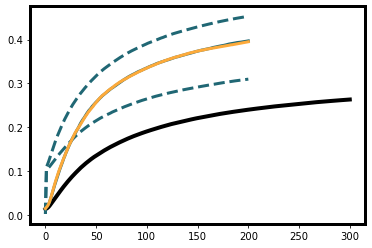

In [183]:
plt.plot(df_all.index, mean_val_un,c='black',label='Original Network',linewidth=4.0)

#plt.plot(t, n_khar,c='#FDAA3A',label='10% Missing Nodes in East',linestyle='dotted',linewidth=3.0)
#plt.plot(t, [i[1] for i in df_un10_e],c='#FDAA3A',label='10% Missing Nodes in East',linestyle='dotted',linewidth=3.0)
#plt.plot(t ,[i[1] for i in df_un50_w_no],c='#206774',linestyle='--', label='30% Missing Nodes in West',linewidth=3.0)
plt.plot(t ,n_df_un10_w,c='#206774',linestyle='--', label='30% Missing Nodes in West',linewidth=3.0)
#plt.plot(t ,n_df_un50_w_no,c='#206774',linestyle='dotted', label='30% Missing Nodes in West',linewidth=3.0)
plt.plot(t ,I2_khar,c='#206774', label='30% Missing Nodes in West',linewidth=3.0)

plt.plot(t ,n_df_un10_entire,c='#206774',linestyle='--', label='30% Missing Nodes in West',linewidth=3.0)
#plt.plot(t ,n_df_un50_w_no,c='#206774',linestyle='dotted', label='30% Missing Nodes in West',linewidth=3.0)
plt.plot(t ,I1_khar,c='#FDAA3A', label='30% Missing Nodes in West',linewidth=3.0)



In [116]:
import pickle
with open ('real_network/epi_network_10%_missing_nodes_6_month_west', 'rb') as fp:
    df_un10_w=pickle.load(fp)
with open ('real_network/epi_network_30%_missing_nodes_6_month_west', 'rb') as fp:
    df_un50_w=pickle.load(fp)
with open ('real_network/epi_network_10%_missing_nodes_6_month_east', 'rb') as fp:
    df_un10_e=pickle.load(fp)
with open ('real_network/epi_network_30%_missing_nodes_6_month_east', 'rb') as fp:
    df_un50_e=pickle.load(fp)
with open ('real_network/epi_network_10%_missing_nodes_6_month_entire', 'rb') as fp:
    df_un10_entire=pickle.load(fp)
with open ('real_network/epi_network_30%_missing_nodes_6_month_entire', 'rb') as fp:
    df_un50_entire=pickle.load(fp)

In [108]:
#number of nodes in original network
n_o=len(DG.nodes())
#number of nodes in the netowrk with added missing nodes
N_10_e=len(MN_DG_e_10.nodes())
N_30_e=len(MN_DG_e_30.nodes())
N_10_w=len(MN_DG_w_10.nodes())
N_30_w=len(MN_DG_w_30.nodes())
N_10=len(MN_DG_10.nodes())
N_30=len(MN_DG_30.nodes())

#modify the results
n_df_un10_e=[i[1]*(n_o/N_10_e) for i in df_un10_e]
n_df_un50_e=[i[1]*(n_o/N_30_e) for i in df_un50_e]
n_df_un10_w=[i[1]*(n_o/N_10_w) for i in df_un10_w]
n_df_un50_w=[i[1]*(n_o/N_30_w) for i in df_un50_w]
n_df_un10_entire=[i[1]*(n_o/N_10) for i in df_un10_entire]
n_df_un50_entire=[i[1]*(n_o/N_30) for i in df_un50_entire]

In [83]:
df_all

,time,vals_1,vals_2,vals_3,vals_4,vals_5
0,0,0.014318,0.014318,0.014318,0.014318,0.014318
1,1,0.015521,0.015335,0.015392,0.015428,0.015457
2,2,0.016982,0.016853,0.016960,0.016896,0.017125
3,3,0.018907,0.018850,0.019172,0.019065,0.019222
4,4,0.021427,0.021492,0.021728,0.021821,0.021843
...,...,...,...,...,...,...
296,296,0.263858,0.261632,0.262369,0.262992,0.263278
297,297,0.264087,0.261847,0.262527,0.263142,0.263465
298,298,0.264288,0.262004,0.262684,0.263314,0.263644
299,299,0.264460,0.262219,0.262849,0.263508,0.263794


In [98]:
#epidemic without missing nodes as initial infected places
import pickle
with open ('real_network/epi_network_10%_missing_nodes_6_month_west_notinf', 'rb') as fp:
    df_un10_w_no=pickle.load(fp)
with open ('real_network/epi_network_30%_missing_nodes_6_month_west_notinf', 'rb') as fp:
    df_un50_w_no=pickle.load(fp)
with open ('real_network/epi_network_10%_missing_nodes_6_month_east_notinf', 'rb') as fp:
    df_un10_e_no=pickle.load(fp)
with open ('real_network/epi_network_30%_missing_nodes_6_month_east_notinf', 'rb') as fp:
    df_un50_e_no=pickle.load(fp)
with open ('real_network/epi_network_10%_missing_nodes_6_month_entire_notinf', 'rb') as fp:
    df_un10_entire_no=pickle.load(fp)
with open ('real_network/epi_network_30%_missing_nodes_6_month_entire_notinf', 'rb') as fp:
    df_un50_entire_no=pickle.load(fp)

In [160]:
n_df_un50_w_no=[i[1]*(len(initial_nodes)/N_30_w) for i in df_un50_w_no]

In [99]:
n_df_un10_e_no=[i[1]*(n_o/N_10_e) for i in df_un10_e_no]
n_df_un50_e_no=[i[1]*(n_o/N_30_e) for i in df_un50_e_no]
n_df_un10_w_no=[i[1]*(n_o/N_10_w) for i in df_un10_w_no]
n_df_un50_w_no=[i[1]*(n_o/N_30_w) for i in df_un50_w_no]
n_df_un10_entire_no=[i[1]*(n_o/N_10) for i in df_un10_entire_no]
n_df_un50_entire_no=[i[1]*(n_o/N_30) for i in df_un50_entire_no]

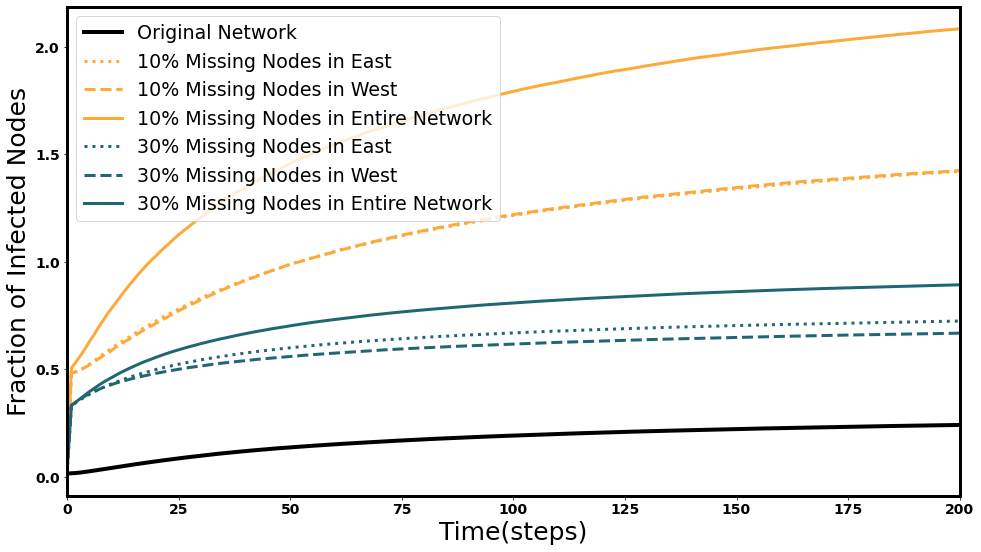

In [82]:
#scatter plot
t=range(0,201)
fig, ax = plt.subplots(1,1,figsize=(16,9))

plt.plot(df_all.index, mean_val_un,c='black',label='Original Network',linewidth=4.0)

plt.plot(t, [i[1] for i in df_un10_e],c='#FDAA3A',label='10% Missing Nodes in East',linestyle='dotted',linewidth=3.0)
#plt.plot(t, [i[1] for i in df_un10_e_no],c='#FDAA3A',label='10% Missing Nodes in East',linestyle='dotted',linewidth=3.0)

plt.plot(t,[i[1] for i in df_un10_w],c='#FDAA3A',linestyle='--',label='10% Missing Nodes in West',linewidth=3.0)
#plt.plot(t,[i[1] for i in df_un10_w_no],c='#FDAA3A',linestyle='--',label='10% Missing Nodes in West',linewidth=3.0)

plt.plot(t,[i[1] for i in df_un10_entire],label='10% Missing Nodes in Entire Network',c='#FDAA3A',linewidth=3.0)
#plt.plot(t,[i[1] for i in df_un10_entire_no],label='10% Missing Nodes in Entire Network',c='#FDAA3A',linewidth=3.0)

plt.plot(t,[i[1] for i in df_un50_e],c='#206774',label='30% Missing Nodes in East',linestyle='dotted',linewidth=3.0)
#plt.plot(t,[i[1] for i in df_un50_e_no],c='#206774',label='30% Missing Nodes in East',linestyle='dotted',linewidth=3.0)

plt.plot(t ,[i[1] for i in df_un50_w],c='#206774',linestyle='--', label='30% Missing Nodes in West',linewidth=3.0)
#plt.plot(t ,[i[1] for i in df_un50_w_no],c='#206774',linestyle='--', label='30% Missing Nodes in West',linewidth=3.0)

plt.plot(t,[i[1] for i in df_un50_entire],label='30% Missing Nodes in Entire Network',c='#206774',linewidth=3.0)
#plt.plot(t,[i[1] for i in df_un50_entire_no],label='30% Missing Nodes in Entire Network',c='#206774',linewidth=3.0)







fontsize = 14

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.rc('axes', linewidth=3)
plt.xlabel('Time(steps)', fontsize=25)
plt.xlim(0,200)
plt.ylabel('Fraction of Infected Nodes',fontsize=25)
#plt.title('a',fontsize=20)
plt.legend(fontsize=19)
#plt.savefig('real_6_month_SI_0.001_missing_node_w_e_1000ININ_10_30.pdf')

In [ ]:
#plot
t=range(0,201)

fig, ax = plt.subplots(1,1,figsize=(16,9))

plt.plot(df_all.index, mean_val_un,c='black',label='Original Network',linewidth=4.0)

plt.plot(t, n_df_un10_e,c='#FDAA3A',label='10% Missing Nodes in East',linestyle='dotted',linewidth=3.0)

plt.plot(t,n_df_un10_w,c='#FDAA3A',linestyle='--',label='10% Missing Nodes in West',linewidth=3.0)

plt.plot(t,n_df_un10_entire,label='10% Missing Nodes in Entire Network',c='#FDAA3A',linewidth=3.0)

plt.plot(t,n_df_un50_e,c='#206774',label='30% Missing Nodes in East',linestyle='dotted',linewidth=3.0)

plt.plot(t ,n_df_un50_w,c='#206774',linestyle='--', label='30% Missing Nodes in West',linewidth=3.0)

plt.plot(t,n_df_un50_entire,label='30% Missing Nodes in Entire Network',c='#206774',linewidth=3.0)







fontsize = 14

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.rc('axes', linewidth=3)
plt.xlabel('Time(steps)', fontsize=25)
plt.xlim(0,200)
plt.ylabel('Fraction of Infected Nodes',fontsize=25)
#plt.title('a',fontsize=20)
plt.legend(fontsize=19)
plt.savefig('real_6_month_SI_0.001_missing_node_w_e_1000ININ_10_30.pdf')

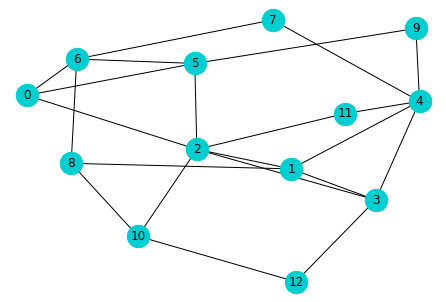

In [76]:
#Draw network for toy example in paper
#barabashi_Albert
G=nx.barabasi_albert_graph(n=13, m =2)
nx.draw(G,node_color ='darkturquoise',node_size = 500,with_labels = True)
#plt.savefig('G_bar_toy.pdf')



In [141]:
from networkx.algorithms import community
import community as community_louvain
comg=community_louvain.best_partition(G)
comg

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 1,
 5: 2,
 6: 3,
 7: 3,
 8: 1,
 9: 0,
 10: 2,
 11: 1,
 12: 0}

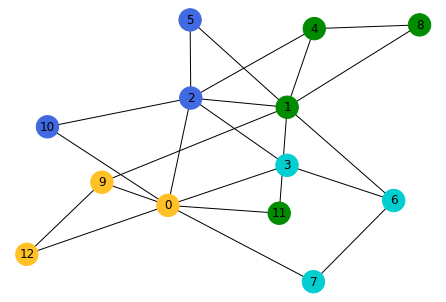

In [175]:
comg={0:'#FFC125',
 1: '#008B00',
 2: 'royalblue',
 3: 'darkturquoise',
 4: '#008B00',
 5: 'royalblue',
 6: 'darkturquoise',
 7: 'darkturquoise',
 8: '#008B00',
 9: '#FFC125',
 10: 'royalblue',
 11: '#008B00',
 12: '#FFC125'}
pos=nx.spring_layout(G,k = 4, iterations = 500, scale =5)
nx.draw(G,node_color =comg.values(),pos=pos,node_size = 500,with_labels = True)
plt.savefig('G_bar_toy_com.pdf')



In [184]:
G.degree()

DegreeView({0: 7, 1: 7, 2: 6, 3: 3, 4: 3, 5: 2, 6: 3, 7: 2, 8: 2, 9: 3, 10: 2, 11: 2, 12: 2})

In [172]:
D=nx.density(G)
D

0.28205128205128205

In [125]:
G1=nx.erdos_renyi_graph(n=13,p=0.244)
d1=nx.density(G1)
d1

0.28205128205128205

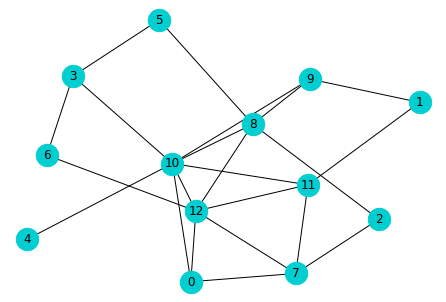

In [127]:
#pos=nx.spring_layout(G1,k = 40, iterations = 500, scale =0.1)
nx.draw(G1,node_color ='darkturquoise',node_size = 500,with_labels = True)
plt.savefig('G_reny_toy.pdf')

In [176]:
from networkx.algorithms import community
import community as community_louvain
comg1=community_louvain.best_partition(G1)
comg1

{0: 0,
 1: 1,
 2: 1,
 3: 2,
 4: 3,
 5: 2,
 6: 2,
 7: 0,
 8: 1,
 9: 1,
 10: 3,
 11: 0,
 12: 0}

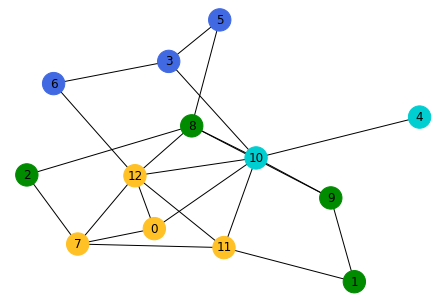

In [180]:
comg1={0: '#FFC125',
 1: '#008B00',
 2: '#008B00',
 3: 'royalblue',
 4: 'darkturquoise',
 5: 'royalblue',
 6: 'royalblue',
 7: '#FFC125',
 8: '#008B00',
 9: '#008B00',
 10: 'darkturquoise',
 11: '#FFC125',
 12: '#FFC125'}
nx.draw(G1,node_color =comg1.values(),node_size = 500,with_labels = True)
plt.savefig('G_reny_toy_com.pdf')

In [126]:
G2=nx.watts_strogatz_graph(n=13,k=4,p=0.5)
d2=nx.density(G2)
d2

0.3333333333333333

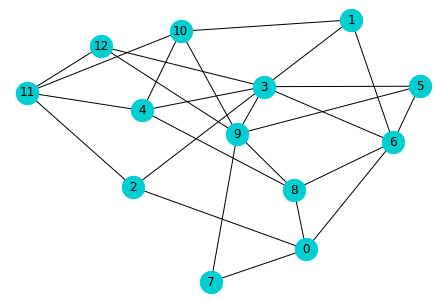

In [129]:
pos=nx.spring_layout(G2,k = 40, iterations = 500, scale =0.1)
nx.draw(G2,node_color ='darkturquoise',node_size = 500,with_labels = True)
plt.savefig('G_watt_toy.pdf')

In [131]:
from networkx.algorithms import community
import community as community_louvain
comg2=community_louvain.best_partition(G2)
comg2

{0: 0,
 1: 1,
 2: 1,
 3: 2,
 4: 1,
 5: 2,
 6: 0,
 7: 0,
 8: 0,
 9: 2,
 10: 1,
 11: 1,
 12: 2}

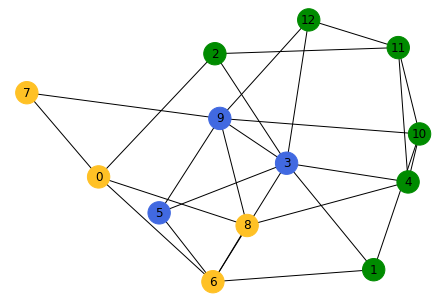

In [182]:
cmg2={0: '#FFC125',
 1: '#008B00',
 2: '#008B00',
 3: 'royalblue',
 4: '#008B00',
 5: 'royalblue',
 6: '#FFC125',
 7: '#FFC125',
 8: '#FFC125',
 9: 'royalblue',
 10: '#008B00',
 11: '#008B00',
 12: '#008B00'}
#pos = nx.spring_layout(G2) 
nx.draw(G2,node_color =cmg2.values(),node_size = 500,with_labels = True)
plt.savefig('G_watt_toy_com.pdf')
#nx.draw_networkx_nodes(G2,pos, nodelist=[1, 2, 4, 10, 11], node_color="r")

In [191]:
def add_uncertainty_node_entire_network_assign_reion_MN_pass(a,graph): #most complete function for add miss nodes
    #a=persenctage of number of nodes, degree verfy number of nodes
                                                         # that the added missing nodes will connect to them
    degree=2
    G_original=graph.copy() 
    North_node=make_node_region_list(G_original,'North')
    East_node=make_node_region_list(G_original,'East')
    Center_node=make_node_region_list(G_original,'Center')
    West_node=make_node_region_list(G_original,'West')
    South_node=make_node_region_list(G_original,'South')
    G=copy.deepcopy(graph)
    N_missing_nodes=int((a*0.01)*G_original.number_of_nodes())
    list_missing_node=[]
    
    list_node_original=list(G_original.nodes())
    for j in range(N_missing_nodes):
        m=0 #counter for number of nodes new node in connecting to them. max=5. it should break if m=5
        node_name='Miss'+str(j)
        list_missing_node.append(node_name)
        G.add_node(node_name)
        #'''
        #Ronaldo said it is not a good idea to shuffle
        #random shuffle does not return any list. random shuffle changes the order of nodes in the original list 
        #random.shuffle(list_original_node)'''
        list_node_connection=[]
        first_node=list(random.sample(list_node_original, 1))[0]
        list_node_connection.append(first_node)
        region_node=G_original.nodes[first_node]['region'] 
        G.nodes[node_name]['region']=region_node
        
        if region_node=='North':
           
            p_random=np.random.choice([1,2,3,4,5] ,1, p=[0.8704, 0.0187, 0.0332, 0.0327, 0.0450])
            #the sum of the p should be equal to 1
            #I brought the dominant region first to save time for run
            if p_random[0]==1:
                second_node=list(random.sample( North_node, 1))[0]
            elif p_random[0]==5:
                second_node=list(random.sample( South_node, 1))[0]
            elif p_random[0]==3:
                second_node=list(random.sample( Center_node, 1))[0]
            elif p_random[0]==4:
                second_node=list(random.sample( West_node, 1))[0]
            else:
                second_node=list(random.sample(East_node, 1))[0]

                
        elif  region_node=='East':
            p_random=np.random.choice([1,2,3,4,5] ,1, p=[0.0144, 0.7157, 0.0617, 0.174, 0.0342])
            if p_random[0]==2:
                second_node=list(random.sample(East_node, 1))[0]
            elif p_random[0]==4:
                second_node=list(random.sample( West_node, 1))[0]
            elif p_random[0]==3:
                second_node=list(random.sample( Center_node, 1))[0]
            elif p_random[0]==5:
                second_node=list(random.sample( South_node, 1))[0]
            else:
                second_node=list(random.sample( North_node, 1))[0]
                        
                
                
                
        elif region_node=='Center':
            p_random=np.random.choice([1,2,3,4,5] ,1, p=[0.0172, 0.0319, 0.7438, 0.0711, 0.136])
            
            if p_random[0]==3:
                second_node=list(random.sample(Center_node, 1))[0]
            elif p_random[0]==5:
                second_node=list(random.sample(South_node, 1))[0]
            elif p_random[0]==4:
                second_node=list(random.sample( West_node, 1))[0]
            elif p_random[0]==2:
                second_node=list(random.sample(East_node, 1))[0]
            else: 
                second_node=list(random.sample( North_node, 1))[0]
            
            
            
        elif region_node=='West':
            p_random=np.random.choice([1,2,3,4,5] ,1, p=[0.0035, 0.0365, 0.0211, 0.9226, 0.0163])
            
            if p_random[0]==4:
                second_node=list(random.sample( West_node, 1))[0]
            elif p_random[0]==2:
                second_node=list(random.sample(East_node, 1))[0]
            elif p_random[0]==3:
                second_node=list(random.sample( Center_node, 1))[0]
            elif p_random[0]==5:
                second_node=list(random.sample( South_node, 1))[0]
            else:
                second_node=list(random.sample( North_node, 1))[0]
           
         
                
        else:
            p_random=np.random.choice([1,2,3,4,5] ,1, p=[0.0153, 0.0176, 0.0565, 0.0227, 0.8879])
            if p_random[0]==5:
                second_node=list(random.sample( South_node, 1))[0]
            elif p_random[0]==3:
                second_node=list(random.sample( Center_node, 1))[0]
            elif p_random[0]==4:
                second_node=list(random.sample( West_node, 1))[0]
            elif p_random[0]==2:
                second_node=list(random.sample(East_node, 1))[0]
            else:
                second_node=list(random.sample( North_node, 1))[0]
      
    
        #list_second_node=make_node_region_list(G_original,region_node) #it is better that have the list outside the loop to be executed once
        
        list_node_connection.append(second_node)
        
        #ازونجایی که تو پیدا کردن ریسک مناطق بخشی از میسینگ نود ها که تو اون منطقه هستن اینیشیال اینفکتد هستن. 
        #باید باقی میسینگ نود ها به ضورت راهی برای انتقال بیماری باش پس باید به لینگ ازونا به نود اضلی سیتم باشه و به لینگ از نود اضلی سیستم به اونا 
        #وگرنه سهم مسینگ نود ها در تاثیر روی سیتم فقط همون تعداد محدودی هست که به منطقه اینیشیال اینفکتد اساین شدن و تغییر زیادی در اپیدمی و ریسک نسبت به نت ورک اصلی نمیفته
    
        #first_node
        dict_neigh=dict(G_original.pred[list_node_connection[0]])#make a list of weights of the edges into to this node in the original network without missing link
        list_w=list(dict_neigh.values())
        list_w=[W['weight'] for W in list_w]
        G.add_edge(node_name,list_node_connection[0])
                #If node in original network do not have any edges and it is isolated the weight of missing link should choosed from weight distribution
        if len(list_w)==0: #if the node is just a source and it does not have in-edge
            G[node_name][list_node_connection[0]]['weight']=list(random.sample(list_weights, 1))[0]
                #if node has neighbors we choose weight for missing link based on weights of other edges of node
        else:
            G.adj[node_name][list_node_connection[0]]['weight']=statistics.mean(list_w)
            
            
            
       #second_node
        dict_neigh=dict(G_original.pred[list_node_connection[1]])#make a list of weights of the edges into to this node in the original network without missing link
        list_w=list(dict_neigh.values())
        list_w=[W['weight'] for W in list_w]
        G.add_edge(list_node_connection[1],node_name)
                #If node in original network do not have any edges and it is isolated the weight of missing link should choosed from weight distribution
        if len(list_w)==0: #if the node is just a source and it does not have in-edge
            G[list_node_connection[1]][node_name]['weight']=list(random.sample(list_weights, 1))[0]
                #if node has neighbors we choose weight for missing link based on weights of other edges of node
        else:
            G.adj[list_node_connection[1]][node_name]['weight']=statistics.mean(list_w)
    
               
        m+=1
            
    return G ,list_missing_node



In [206]:
list_weights=[]
for (u,v) in DG.edges():
        list_weights.append(DG.adj[u][v]['weight'])
MN_DG_30day_10, list_MN_10=add_uncertainty_node_entire_network_assign_reion_MN_pass(10,DG)
MN_DG_30day_20, list_MN_20=add_uncertainty_node_entire_network_assign_reion_MN_pass(20,DG)

IN_IN_risk_region=random.sample(list(DG.nodes()),1000)
IN_IN_10=IN_IN_risk_region+list_MN_10
IN_IN_20=IN_IN_risk_region+random.sample(list_MN_20,len(list_MN_10))

In [221]:
initial_nodes=list(DG.nodes())
I1,u=My_Epi_SI_for_missing_node_method(MN_DG_30day_20,initial_nodes,IN_IN_20)
I2,u=My_Epi_SI_for_missing_node_method(MN_DG_30day_10,initial_nodes,IN_IN_10)

In [210]:
len(I1)

51

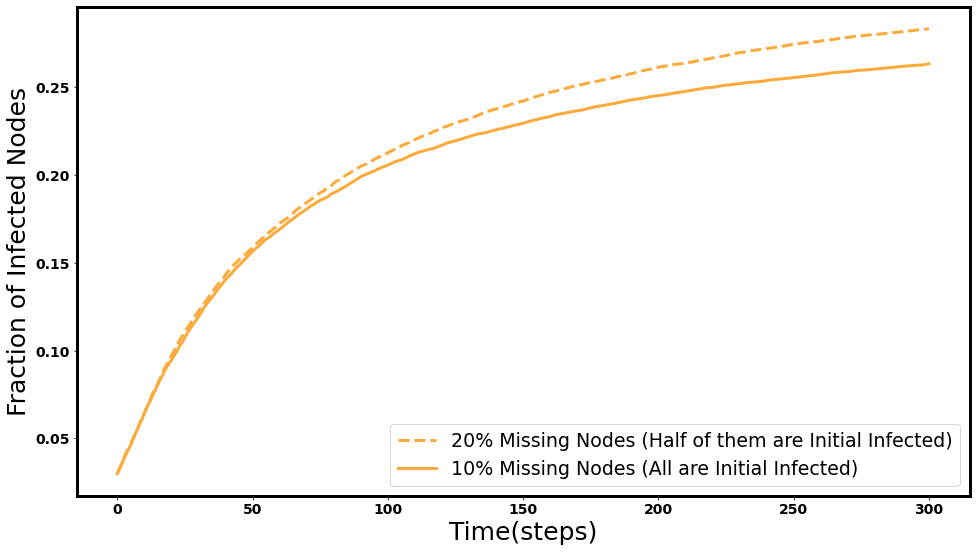

In [226]:
t=range(0,301)
fig, ax = plt.subplots(1,1,figsize=(16,9))


plt.plot(t, I1,c='#FDAA3A',linestyle='--',label='20% Missing Nodes (Half of them are Initial Infected)',linewidth=3.0)

plt.plot(t,I2,label='10% Missing Nodes (All are Initial Infected)',c='#FDAA3A',linewidth=3.0)



fontsize = 14

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
plt.rc('axes', linewidth=3)
plt.xlabel('Time(steps)', fontsize=25)
#plt.xlim(0,50)
plt.ylabel('Fraction of Infected Nodes',fontsize=25)
#plt.title('a',fontsize=20)
plt.legend(fontsize=19)
plt.savefig('real_30days_SI_0.001_missing_node_100ININ_comparison_10_20.pdf')